### **Deep Learning**

---

**Image Classification**

**Assignment 2: Abnormality Detection in bone X-Rays**

**Prof: Prodromos Malakasiotis**

**Author: Andreas Stavrou**

---

**Objective**: *Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal.*

### **TODO**:

* 1) Take whatever works the best and fit all bodyparts to showcase how it did. 
* 2) If I feed the last model with the whole dataset, will it make a difference? (maybe ask prof before you do that)
* 3) Finish report with last results
* 4) Print cnn 

Remarks: When trained on the whole dataset, the densenet201 scored 0.55 which is about the same as the highest scored body parts. Maybe do a confusion matrix on that and see which categories lacking?

Don't forget to check for **!**

### **Helper Functions and Data Manipulation**

##### **Importing libraries**

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from keras_adabound import AdaBound
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation,SpatialDropout2D,AvgPool2D
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense
from tensorflow.keras.layers import average, concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.applications import ResNet152V2, Xception,InceptionV3
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.models import load_model
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50


#### **Helper Code**

In [2]:
# define seed number to have reproducible experiments.
seed = 1994
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [4]:
def metrics():
    return [
        AUC(name="auc"),
        BinaryAccuracy("accuracy"),
        CohenKappa(name="kappa", num_classes=2)
    ]

**!** The paper is using weighted binary cross entropy loss 

$L(X,y) = −wT,1·ylogp(Y=1|X) $
        
$       = −wT,0·(1−y)logp(Y =0|X),$

Maybe I could try to approach that, sample code bellow to work if possible. Currently not being used!

In [5]:
# Backbone implementation for weighted loss
def weighted_bce(y_true, y_pred):
  weights = (y_true * 59.) + 1.
  bce = K.binary_crossentropy(y_true, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce

#### **Loading Dataset**

In [6]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [7]:
path = 'MURA-v1.1/train'
os.listdir(path)

['XR_HAND',
 'XR_HUMERUS',
 'XR_FINGER',
 'XR_ELBOW',
 'XR_SHOULDER',
 'XR_WRIST',
 'XR_FOREARM']

**Train set**

In [8]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_HAND,patient05509,0,MURA-v1.1/train/XR_HAND/patient05509/study1_ne...
1,XR_HAND,patient05509,0,MURA-v1.1/train/XR_HAND/patient05509/study1_ne...
2,XR_HAND,patient05509,0,MURA-v1.1/train/XR_HAND/patient05509/study1_ne...
3,XR_HAND,patient11109,0,MURA-v1.1/train/XR_HAND/patient11109/study1_ne...
4,XR_HAND,patient11109,0,MURA-v1.1/train/XR_HAND/patient11109/study1_ne...


In [9]:
dataset_test = load_path(path = 'MURA-v1.1/valid')
df_test = pd.DataFrame(dataset_test)
df_test.head()

,body_part,patient_id,label,img_path
0,XR_HAND,patient11599,0,MURA-v1.1/valid/XR_HAND/patient11599/study1_ne...
1,XR_HAND,patient11599,0,MURA-v1.1/valid/XR_HAND/patient11599/study1_ne...
2,XR_HAND,patient11304,1,MURA-v1.1/valid/XR_HAND/patient11304/study1_po...
3,XR_HAND,patient11304,1,MURA-v1.1/valid/XR_HAND/patient11304/study1_po...
4,XR_HAND,patient11304,1,MURA-v1.1/valid/XR_HAND/patient11304/study1_po...


#### **Data Processing**

**Training set**

In [10]:
#csv files path
path = 'MURA-v1.1'
train_image_paths_csv = "train_image_paths.csv"

In [11]:
train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
train_images_paths.columns = ['image_path']

In [12]:
train_images_paths['label'] = train_images_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
train_images_paths['category']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[2])  
train_images_paths['patientId']  = train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_images_paths.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


**Test set**

In [13]:
path = 'MURA-v1.1'
valid_image_paths_csv = "valid_image_paths.csv"
valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
valid_data_paths.columns = ['image_path']

In [14]:
valid_data_paths['label'] = valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_data_paths['category']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])  
valid_data_paths['dir'] =  valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
valid_data_paths['patientId']  = valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_data_paths.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [15]:
train_images_paths['label_index']= train_images_paths.label

In [16]:
train_images_paths.label_index.replace('positive', 1, inplace=True)
train_images_paths.label_index.replace('negative', 0, inplace=True)
train_images_paths.head(3)

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,1


In [17]:
valid_data_paths['label_index']= valid_data_paths.label
valid_data_paths.label_index.replace('positive', 1, inplace=True)
valid_data_paths.label_index.replace('negative', 0, inplace=True)
valid_data_paths.head(3)

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,1


**Image preprocessing for creating of dataset**

In [18]:
im_size = 256 

In [19]:
def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

**Image / Dataset Loader with random rotation flip**

In [20]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

In [21]:
X_train = image_loader(train_images_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 568.36it/s]


In [22]:
y_train = train_images_paths['label']
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

In [23]:
X_test = image_loader(valid_data_paths['image_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 646.20it/s]


In [24]:
y_test = valid_data_paths['label']
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

In [25]:
from skimage.io import imread
sub_df = train_images_paths.groupby(['category', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['image_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{label}'.format(**c_row))

**Train validation sets created out of train images**

In [26]:
train, valid = train_test_split(train_images_paths, test_size=0.2,random_state=seed)

In [27]:
test = valid_data_paths.drop(['dir'], axis=1)

**Data preparation to feed the neural network**

*From the paper about augmentation*

Before feeding images into the network, we normalized each image to have the same mean and standard deviation of images in the ImageNet training set. We then scaled the variable-sized images to 320 × 320. We augmented the data during training by applying random lateral inversions and rotations of up to 30 degrees.

In [28]:
from keras.applications.inception_v3 import preprocess_input 

train_gen = ImageDataGenerator(
    rotation_range= 0.3 ,
    brightness_range= None,
    horizontal_flip= True,
    fill_mode="constant",
    cval=0.0,
    preprocessing_function = preprocess_input
)
train_iter = train_gen.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)

Found 29446 non-validated image filenames.


In [29]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

In [30]:
path = 'MURA-v1.1'

In [31]:
train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

Found 29446 non-validated image filenames.
Found 7362 validated image filenames.
Found 3197 validated image filenames.


In [32]:
CLASSES = 2
input_shape = (im_size,im_size,3)

#### **Taking less data for testing - I am selecting one body part, the forearm**

In [33]:
train_less = train_images_paths[train_images_paths["category"] == "XR_FOREARM"]
valid_less = valid_data_paths[valid_data_paths["category"] == "XR_FOREARM"]

X_train = image_loader(train_less['image_path'][:50,],im_size)

y_train = train_less['label']
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

X_test = image_loader(valid_less['image_path'][:50,],im_size)

y_test = valid_less['label']
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

train, valid = train_test_split(train_less, test_size=0.2,random_state=seed)

test = valid_less.drop(['dir'], axis=1)

image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

path = 'MURA-v1.1'

train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

CLASSES = 2
input_shape = (im_size,im_size,3)

100%|██████████| 50/50 [00:00<00:00, 515.81it/s]

Found 1460 non-validated image filenames.
Found 365 validated image filenames.
Found 301 validated image filenames.


#### **Custom function for plotting results**

In [34]:
def plot_history(hs, epochs, metric):
    if metric=='loss': 
                label_y = 'Loss'
    elif metric=='accuracy': 
               label_y = 'Accuracy'
    elif metric=='auc': 
               label_y = 'AUC'
    else : label_y = 'kappa'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

def print_results(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))
    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='auc')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='kappa')

In [35]:
def print_results_without_plots(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train AUC     : {0:.5f}".format(hs.history['auc'][-1]))
    print("Validation AUC: {0:.5f}".format(hs.history['val_auc'][-1]))
    print("Test AUC      : {0:.5f}".format(model_eval[1]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[2]))
    print("---")
    print("Train Kappa     : {0:.5f}".format(hs.history['kappa'][-1]))
    print("Validation Kappa: {0:.5f}".format(hs.history['kappa'][-1]))
    print("Test Kappa      : {0:.5f}".format(model_eval[3]))

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **CNN models**

#### **Model 1: Basic CNN**

In [37]:
def cnn_builder(
        input_shape=(256, 256, 3),
        starting_filters=32,
        conv_layers=1,
        conv_strides=(1, 1),
        conv_kernel=(3, 3),
        convs_per_layer=1,
        batch_norm=False,
        pooling="max",
        dropout=None,
        pool_size=(2, 2),
        pool_strides=(2, 2),
        last_pooling=None,
        spatial_dropout=None,
        last_dropout=None,
):
    inputs = Input(
        shape=input_shape,
        name="input"
    )
    x = inputs
    for conv_level in range(conv_layers):
        current_filters = starting_filters * (2 ** conv_level)
        for conv_number in range(convs_per_layer):
            x = Conv2D(
                filters=current_filters,
                kernel_size=conv_kernel,
                strides=conv_strides,
                name=f"conv_{conv_level}_{conv_number}",
                padding='same'
            )(x)
            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)
            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)
        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)
        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size, 
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size,
                          strides=pool_strides,
                          name=f"mp_{conv_level}",
                          padding='same')(x)
        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)
    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)
    x = Flatten(name="flatten")(x)
    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)
    output = Dense(1, activation='sigmoid', name="output")(x)
    model = Model(inputs=inputs, outputs=output)
    return model

Epoch 1/50
23/23 [==============================] - 18s 708ms/step - loss: 0.6631 - auc: 0.4865 - accuracy: 0.6356 - kappa: -0.0018 - val_loss: 0.6476 - val_auc: 0.6000 - val_accuracy: 0.6301 - val_kappa: 0.0000e+00
Epoch 2/50
23/23 [==============================] - 15s 667ms/step - loss: 0.6406 - auc: 0.6015 - accuracy: 0.6507 - kappa: 0.0575 - val_loss: 0.6484 - val_auc: 0.5949 - val_accuracy: 0.6466 - val_kappa: 0.1129
Epoch 3/50
23/23 [==============================] - 15s 658ms/step - loss: 0.6281 - auc: 0.6236 - accuracy: 0.6712 - kappa: 0.1735 - val_loss: 0.6534 - val_auc: 0.5806 - val_accuracy: 0.6274 - val_kappa: 0.1017
Epoch 4/50
23/23 [==============================] - 15s 659ms/step - loss: 0.6060 - auc: 0.6695 - accuracy: 0.6760 - kappa: 0.1852 - val_loss: 0.6573 - val_auc: 0.6056 - val_accuracy: 0.6411 - val_kappa: 0.0691
Epoch 5/50
23/23 [==============================] - 16s 671ms/step - loss: 0.5647 - auc: 0.7369 - accuracy: 0.7137 - kappa: 0.3095 - val_loss: 0.6928 -

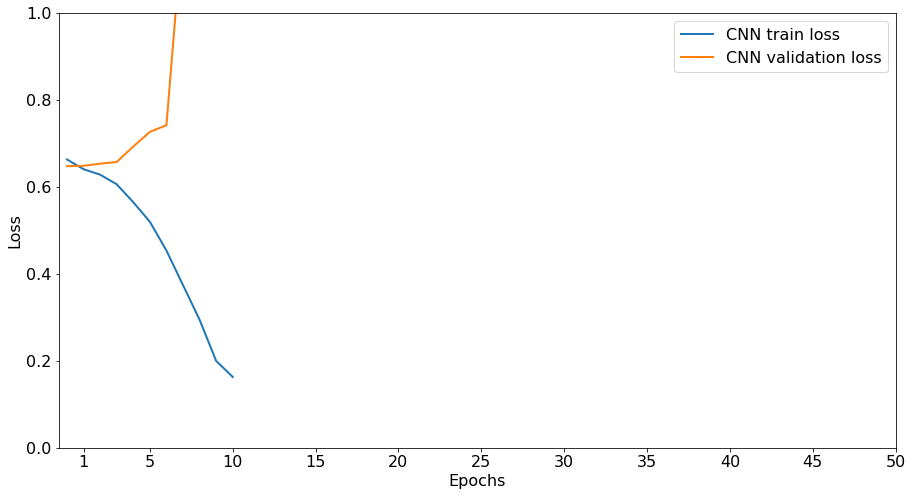

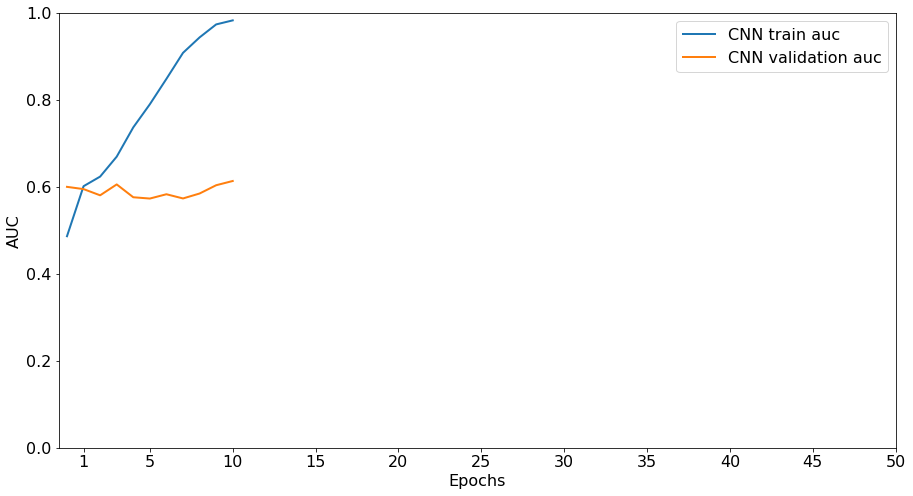

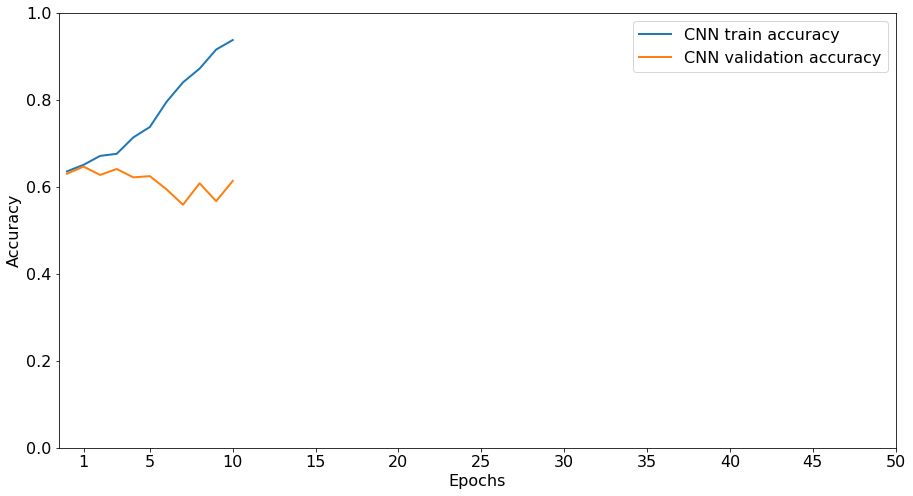

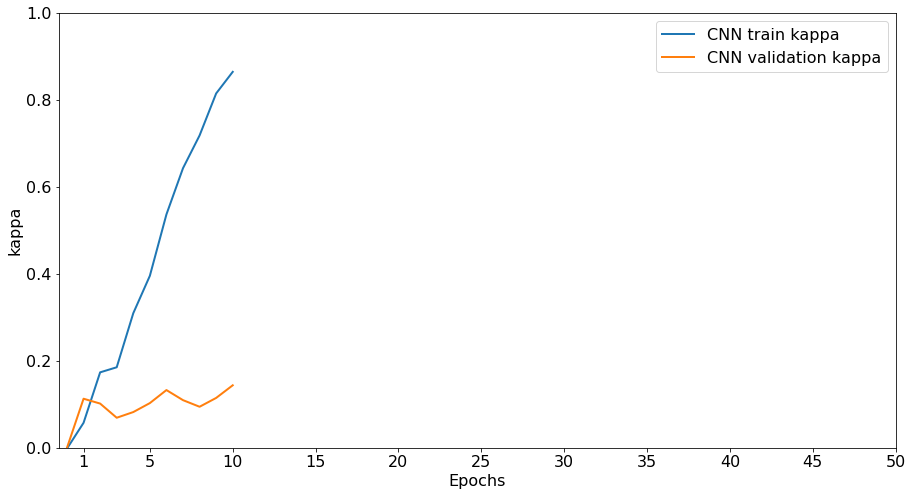

In [ ]:
epochs = 50
cnn_model = cnn_builder(starting_filters=32,conv_layers=4,convs_per_layer=1,pooling='max')
cnn_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
early_stop = EarlyStopping(monitor="val_loss",mode="min", patience=10,restore_best_weights=True)
hs = cnn_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Training.')
print('------------------')
cnn_model.summary()
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

In [ ]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_0_0 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv_0_0_relu (Activation)  (None, 256, 256, 32)      0         
                                                                 
 mp_0 (MaxPooling2D)         (None, 128, 128, 32)      0         
                                                                 
 conv_1_0 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv_1_0_relu (Activation)  (None, 128, 128, 64)      0         
                                                                 
 mp_1 (MaxPooling2D)         (None, 64, 64, 64)        0     

Train Loss     : 0.16298
Validation Loss: 1.54961
Test Loss      : 0.71636
---
Train AUC     : 0.98287
Validation AUC: 0.61353
Test AUC      : 0.60898
---
Train Accuracy     : 0.93767
Validation Accuracy: 0.61370
Test Accuracy      : 0.49834
---
Train Kappa     : 0.86450
Validation Kappa: 0.86450
Test Kappa      : 0.00000


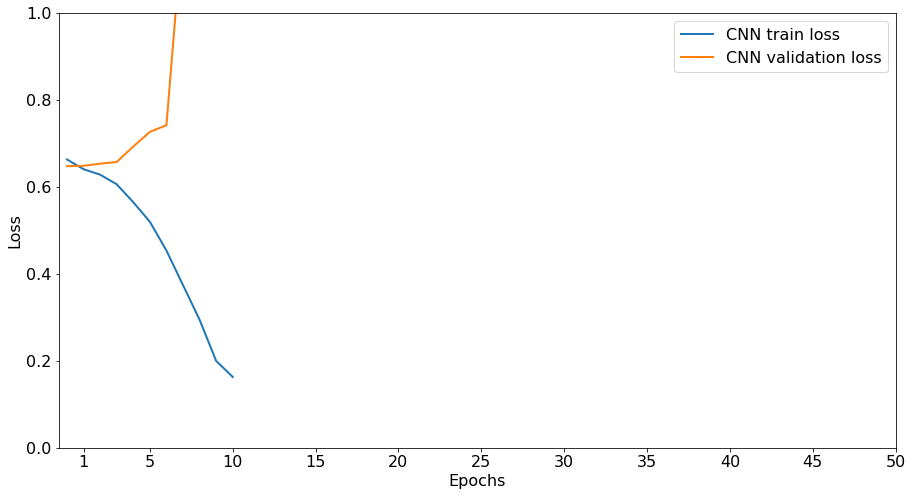

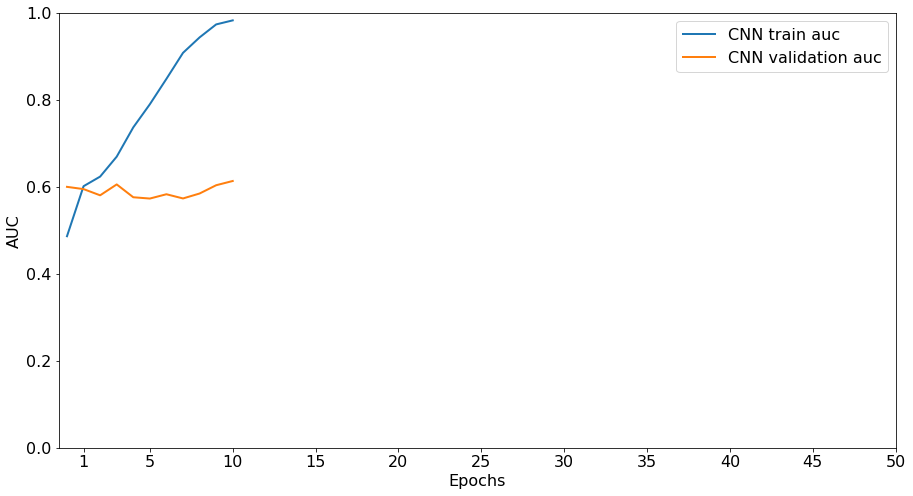

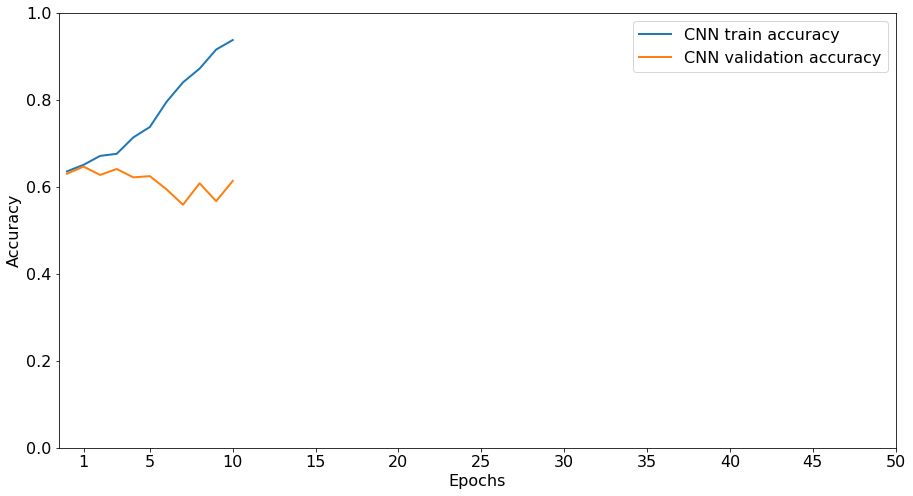

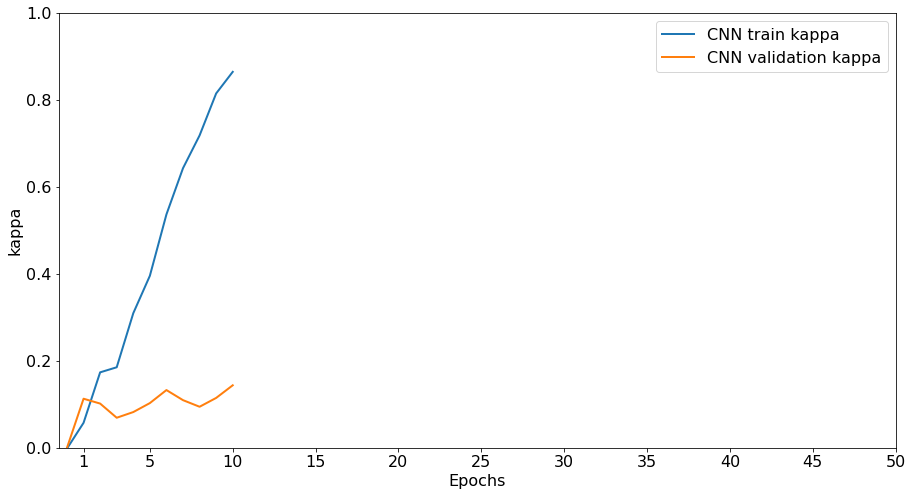

In [ ]:
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

#### **Model 2: CNN Architecture with dropout and AdaBound optimizer**

/Users/andreas/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/keras_adabound/optimizers.py:48: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(AdaBound, self).__init__(name=name, **kwargs)


Epoch 1/50
23/23 [==============================] - 26s 957ms/step - loss: 2.7131 - auc: 0.5211 - accuracy: 0.5603 - kappa: 0.0522 - val_loss: 0.9220 - val_auc: 0.5410 - val_accuracy: 0.6438 - val_kappa: 0.0549
Epoch 2/50
23/23 [==============================] - 20s 884ms/step - loss: 1.1609 - auc: 0.5874 - accuracy: 0.6151 - kappa: 0.1486 - val_loss: 0.9184 - val_auc: 0.5329 - val_accuracy: 0.4575 - val_kappa: 0.0799
Epoch 3/50
23/23 [==============================] - 20s 868ms/step - loss: 0.9874 - auc: 0.6180 - accuracy: 0.6377 - kappa: 0.1740 - val_loss: 0.9296 - val_auc: 0.5406 - val_accuracy: 0.4137 - val_kappa: 0.0245
Epoch 4/50
23/23 [==============================] - 20s 872ms/step - loss: 0.8358 - auc: 0.6482 - accuracy: 0.6438 - kappa: 0.1985 - val_loss: 1.1225 - val_auc: 0.4815 - val_accuracy: 0.4027 - val_kappa: -0.0046
Epoch 5/50
23/23 [==============================] - 21s 893ms/step - loss: 0.9812 - auc: 0.6558 - accuracy: 0.6616 - kappa: 0.2504 - val_loss: 1.0484 - val

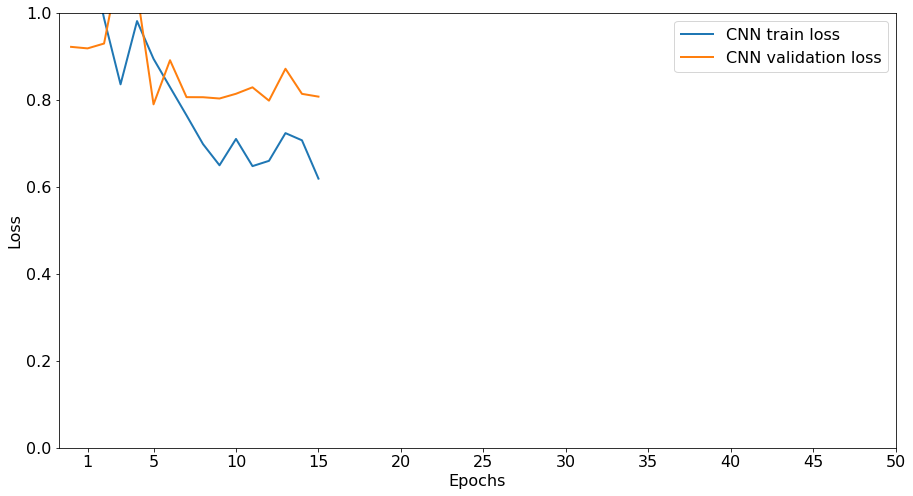

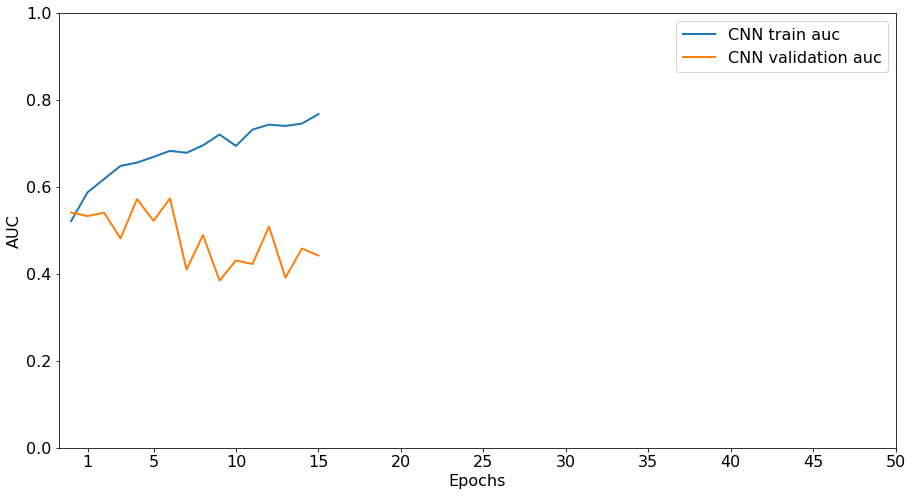

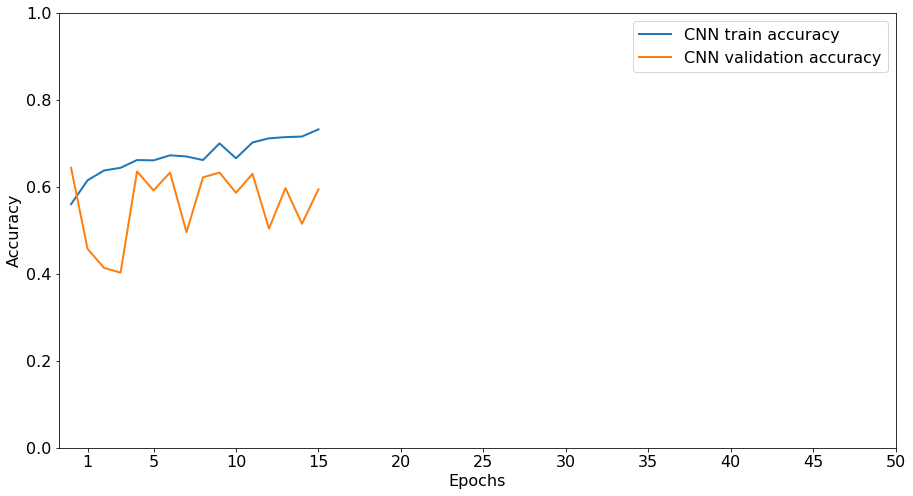

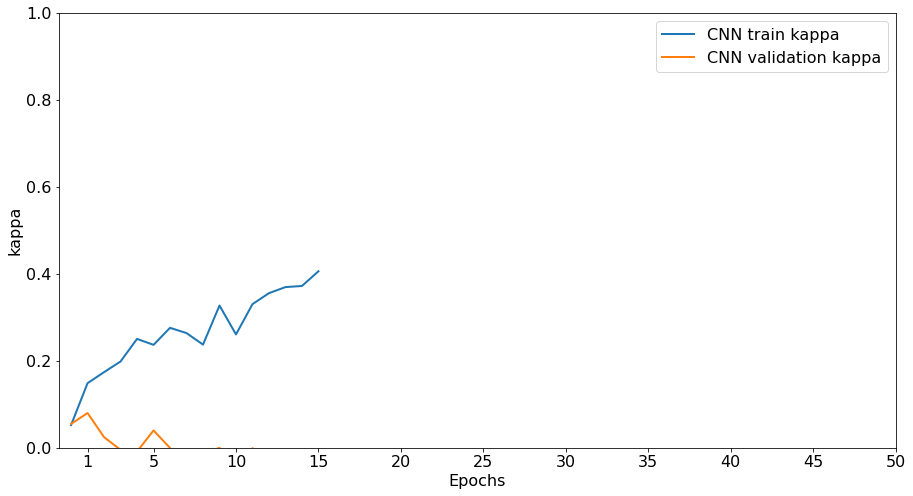

In [104]:
epochs = 50
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
cnn_model = cnn_builder(starting_filters=32,
conv_layers=4,convs_per_layer=1,pooling='avg',batch_norm=True,dropout=0.2,pool_strides=(2, 2))
cnn_model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = cnn_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
cnn_model.summary()
cnn_model_eval = cnn_model.evaluate(test_generator)
clean_up(model=cnn_model)
print_results(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

In [109]:
filename = 'tmp/models/model2.h5'
cnn_model.save(filename)

### **Transfer learning**

#### **Model 3: Densenet201 Architecture (with Avg Pooling and Mlp) - ReduceLRoPl** 

In [105]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

------------

Fitting same model with augmented data 

Epoch 1/30
461/461 [==============================] - 1156s 2s/step - loss: 0.5113 - auc: 0.8142 - accuracy: 0.7638 - kappa: 0.4941 - val_loss: 0.5205 - val_auc: 0.8240 - val_accuracy: 0.7586 - val_kappa: 0.4510 - lr: 0.0010
Epoch 2/30
461/461 [==============================] - 1352s 3s/step - loss: 0.4498 - auc: 0.8568 - accuracy: 0.8020 - kappa: 0.5777 - val_loss: 0.5081 - val_auc: 0.8308 - val_accuracy: 0.7709 - val_kappa: 0.5210 - lr: 0.0010
Epoch 3/30
461/461 [==============================] - 1560s 3s/step - loss: 0.4253 - auc: 0.8737 - accuracy: 0.8148 - kappa: 0.6061 - val_loss: 0.4959 - val_auc: 0.8276 - val_accuracy: 0.7755 - val_kappa: 0.5021 - lr: 0.0010
Epoch 4/30
461/461 [==============================] - 1551s 3s/step - loss: 0.4008 - auc: 0.8878 - accuracy: 0.8291 - kappa: 0.6373 - val_loss: 0.5160 - val_auc: 0.8260 - val_accuracy: 0.7699 - val_kappa: 0.4868 - lr: 0.0010
Epoch 5/30
461/461 [==============================] - 1415s 3s/step - loss: 0.3307 - auc: 0.9244 - a

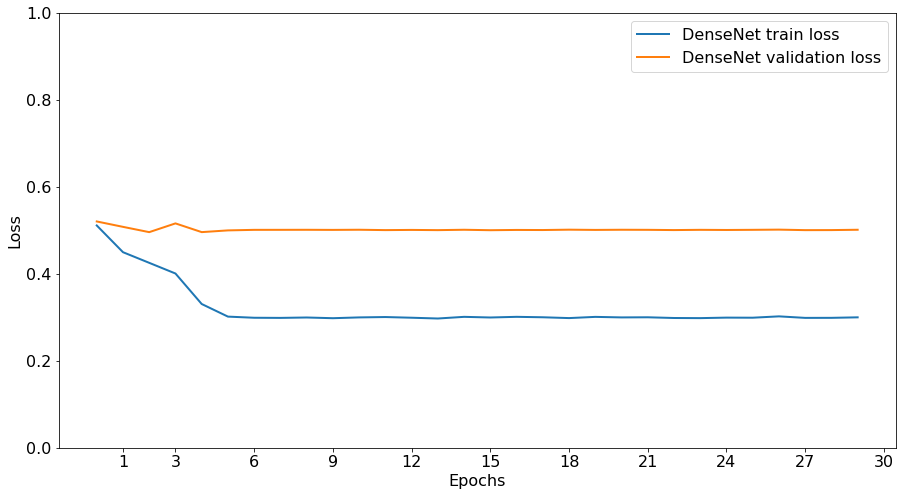

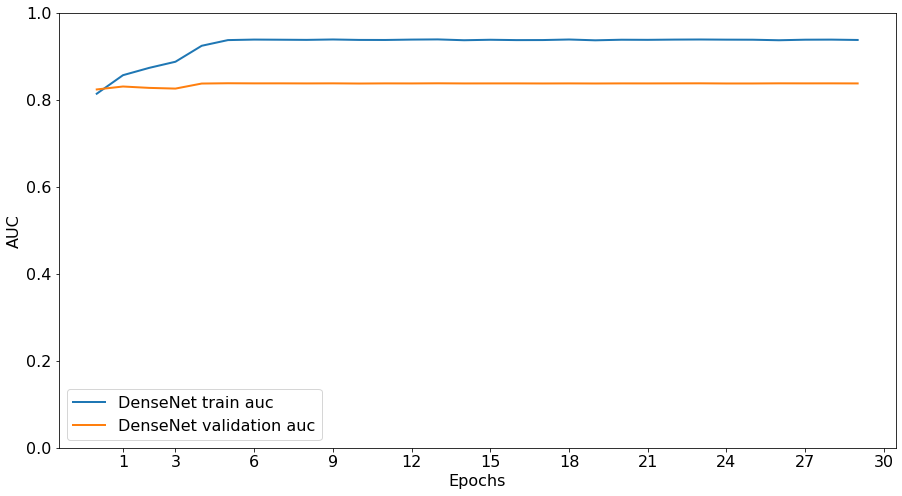

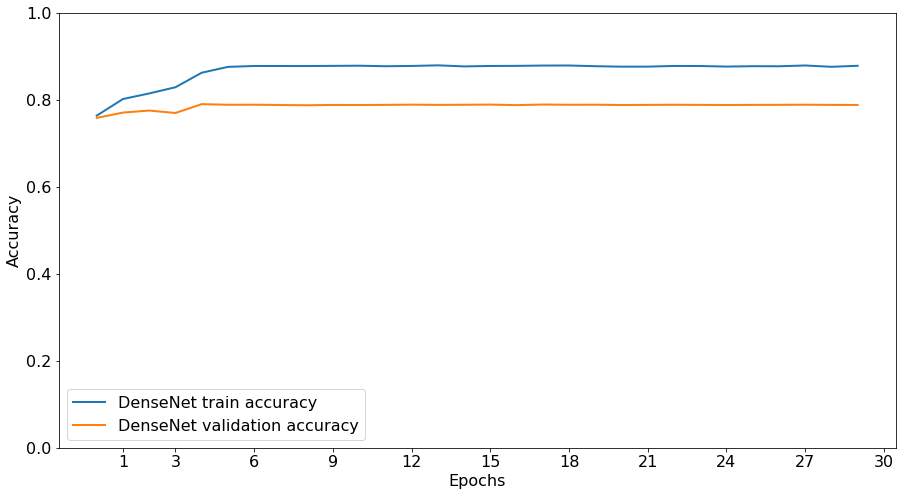

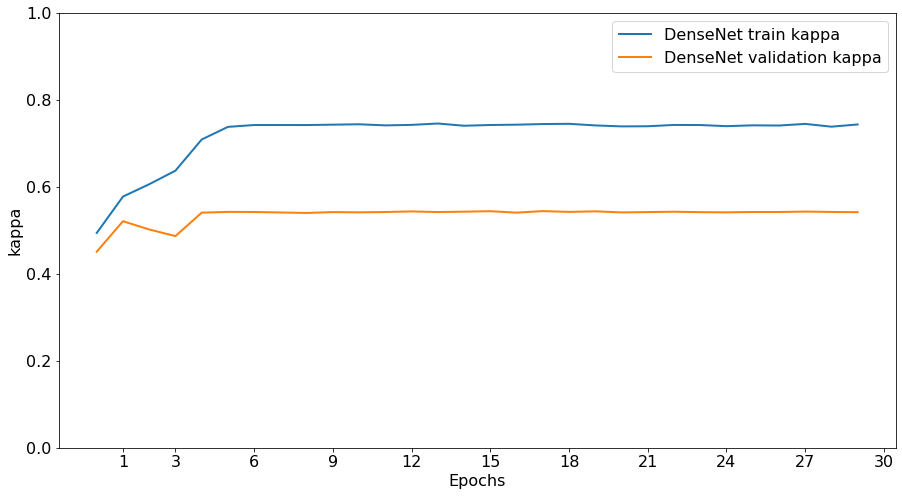

Train Loss     : 0.30000
Validation Loss: 0.50137
Test Loss      : 0.51013
---
Train AUC     : 0.93781
Validation AUC: 0.83788
Test AUC      : 0.85485
---
Train Accuracy     : 0.87842
Validation Accuracy: 0.78837
Test Accuracy      : 0.78136
---
Train Kappa     : 0.74354
Validation Kappa: 0.74354
Test Kappa      : 0.55743


In [106]:
epochs = 30

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.25)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

In [189]:
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.11707
Validation Loss: 0.54621
Test Loss      : 0.53257
---
Train AUC     : 0.99107
Validation AUC: 0.83878
Test AUC      : 0.86318
---
Train Accuracy     : 0.96507
Validation Accuracy: 0.82192
Test Accuracy      : 0.78738
---
Train Kappa     : 0.92381
Validation Kappa: 0.92381
Test Kappa      : 0.57493


------------------------------------------

Without data augmentation

In [41]:
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.03201
Validation Loss: 0.63289
Test Loss      : 0.60750
---
Train AUC     : 0.99969
Validation AUC: 0.85704
Test AUC      : 0.87146
---
Train Accuracy     : 0.99589
Validation Accuracy: 0.80822
Test Accuracy      : 0.77741
---
Train Kappa     : 0.99108
Validation Kappa: 0.99108
Test Kappa      : 0.55518


With data augmentation 

In [190]:
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.11707
Validation Loss: 0.54621
Test Loss      : 0.53257
---
Train AUC     : 0.99107
Validation AUC: 0.83878
Test AUC      : 0.86318
---
Train Accuracy     : 0.96507
Validation Accuracy: 0.82192
Test Accuracy      : 0.78738
---
Train Kappa     : 0.92381
Validation Kappa: 0.92381
Test Kappa      : 0.57493


In [39]:
densenet_model.summary()

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [38]:
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.04828
Validation Loss: 1.22326
Test Loss      : 0.93999
---
Train AUC     : 0.99674
Validation AUC: 0.81470
Test AUC      : 0.86333
---
Train Accuracy     : 0.98425
Validation Accuracy: 0.81096
Test Accuracy      : 0.76744
---
Train Kappa     : 0.96587
Validation Kappa: 0.96587
Test Kappa      : 0.53549


In [191]:
filename = 'tmp/models/model3.h5'
densenet_model.save(filename)

#### **Model 4: VGG16 Architecture**

In [37]:
def VGGNET16_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    VGGNET16 = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in VGGNET16.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET16.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET16,
            prediction_layer
        ],
        name="VGGNET16"
    )
    return model

Epoch 1/5
461/461 [==============================] - 1389s 3s/step - loss: 0.5921 - auc: 0.7375 - accuracy: 0.6910 - kappa: 0.3252 - val_loss: 0.5836 - val_auc: 0.7947 - val_accuracy: 0.7589 - val_kappa: 0.4764 - lr: 0.0010
Epoch 2/5
461/461 [==============================] - 1524s 3s/step - loss: 0.5226 - auc: 0.7989 - accuracy: 0.7452 - kappa: 0.4464 - val_loss: 0.6155 - val_auc: 0.8208 - val_accuracy: 0.6301 - val_kappa: 0.3181 - lr: 0.0010
Epoch 3/5
461/461 [==============================] - 1459s 3s/step - loss: 0.4844 - auc: 0.8324 - accuracy: 0.7744 - kappa: 0.5119 - val_loss: 0.5221 - val_auc: 0.8287 - val_accuracy: 0.7863 - val_kappa: 0.5387 - lr: 1.0000e-04
Epoch 4/5
461/461 [==============================] - 1465s 3s/step - loss: 0.4764 - auc: 0.8389 - accuracy: 0.7787 - kappa: 0.5219 - val_loss: 0.5149 - val_auc: 0.8242 - val_accuracy: 0.7836 - val_kappa: 0.5292 - lr: 1.0000e-04
Epoch 5/5
461/461 [==============================] - 1470s 3s/step - loss: 0.4696 - auc: 0.8438 

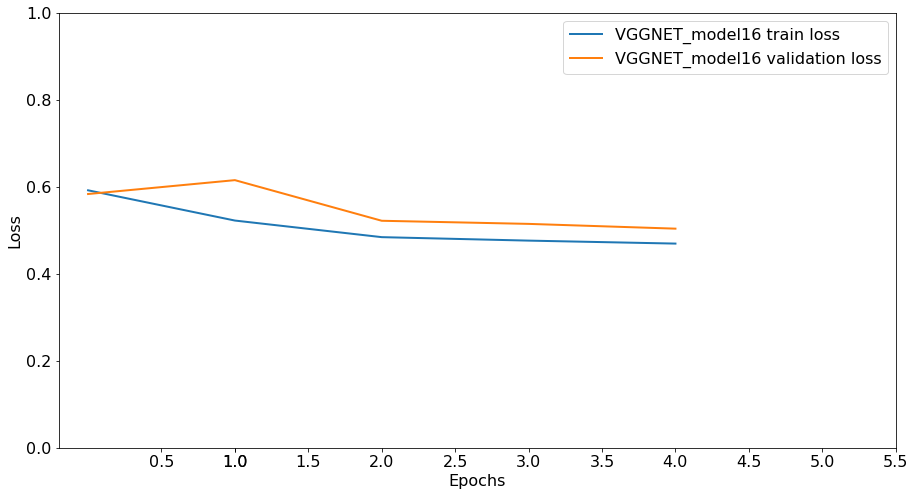

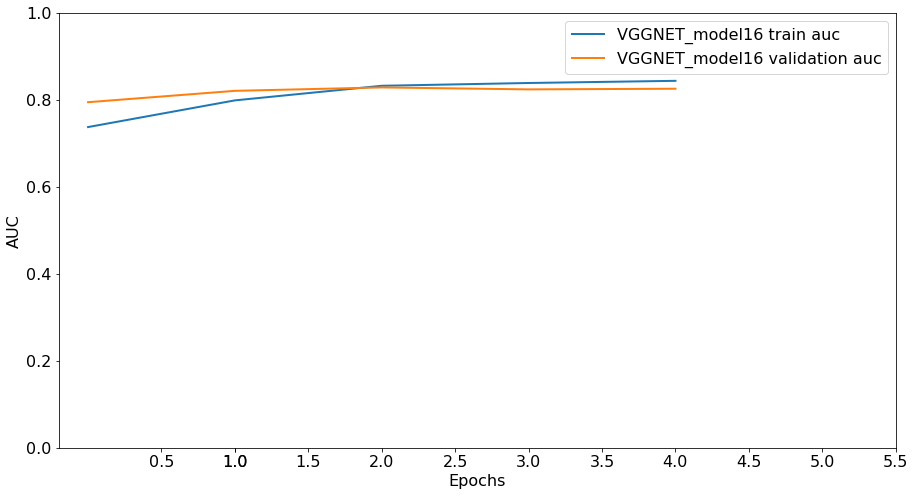

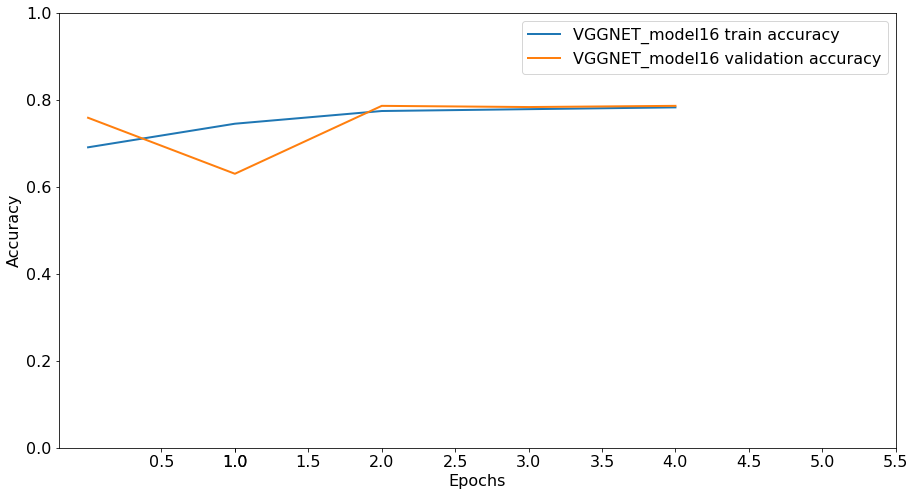

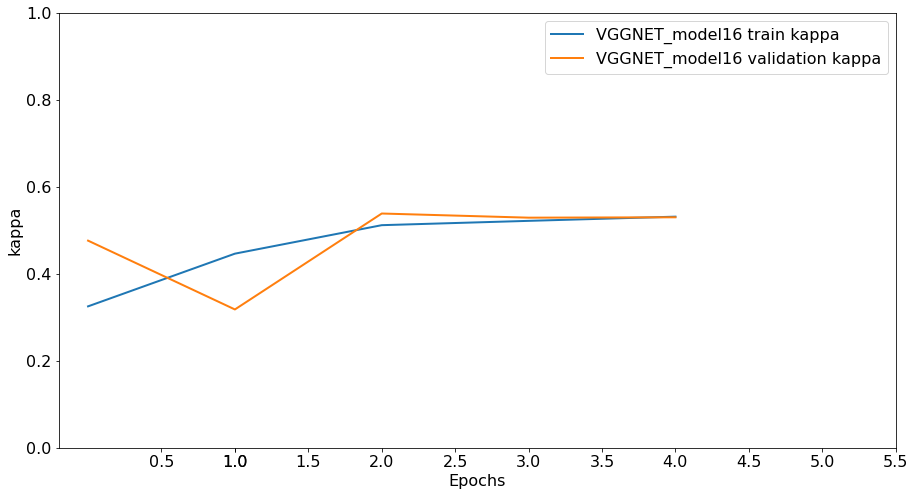

In [38]:
epochs = 5
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=1,
                              mode='auto') # Just like the paper suggests

VGGNET_model16 = VGGNET16_builder(pooling='avg', 
                                  trainable_layers_after=16)

VGGNET_model16.compile(optimizer=Adam(),
                       loss= BinaryCrossentropy(from_logits=False),
                       metrics=[metrics()])

hs = VGGNET_model16.fit(train_iter,
                        validation_data = valid_generator, 
                        epochs = epochs,
                        callbacks=[reduce_lr, early_stop])
print('Finished training.')
print('------------------')
VGGNET_model16.summary()
filename = 'tmp/models/model4.h5'
VGGNET_model16.save(filename)
VGGNET_model_eval = VGGNET_model16.evaluate(test_generator)
clean_up(model=VGGNET_model16)
print_results(model_name='VGGNET_model16',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

In [39]:
print_results_without_plots(model_name='VGGNET_model16',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

Train Loss     : 0.46958
Validation Loss: 0.50393
Test Loss      : 0.50226
---
Train AUC     : 0.84384
Validation AUC: 0.82568
Test AUC      : 0.82740
---
Train Accuracy     : 0.78282
Validation Accuracy: 0.78630
Test Accuracy      : 0.76744
---
Train Kappa     : 0.53150
Validation Kappa: 0.53150
Test Kappa      : 0.53527


#### **Model 5: VGG19 Architecture**

In [40]:
def VGGNET19_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    VGGNET19 = VGG19(include_top=False,weights='imagenet',input_shape=shape,pooling=pooling)
    if trainable_layers_after:
        for layer in VGGNET19.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET19.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET19,
            prediction_layer
        ],
        name="VGGNET19"
    )
    return model

In [245]:
epochs = 50

early_stop = EarlyStopping(monitor="kappa",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

VGGNET_model19 = VGGNET19_builder(pooling='avg',
                                  trainable_layers_after=20)

VGGNET_model19.compile(optimizer=Adam(), 
                       loss= BinaryCrossentropy(from_logits=False),
                       metrics=[metrics()])

hs = VGGNET_model19.fit(train_generator,
                        validation_data = valid_generator, 
                        epochs = epochs,
                        callbacks=[reduce_lr, early_stop])  
                        
print('Finished training.')  
print('------------------')
VGGNET_model19.summary()
filename = 'tmp/models/model5.h5'
VGGNET_model19.save(filename)
VGGNET_model_eval = VGGNET_model19.evaluate(test_generator)
clean_up(model=VGGNET_model19)
print_results(model_name='VGGNET_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

Epoch 1/50
 1/23 [>.............................] - ETA: 1:54 - loss: 0.7628 - auc: 0.4015 - accuracy: 0.3906 - kappa: 0.0000e+00

In [ ]:
print_results_without_plots(model_name='VGGNET_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

Train Loss     : 0.65048
Validation Loss: 0.63963
Test Loss      : 0.72133
---
Train AUC     : 0.61597
Validation AUC: 0.65637
Test AUC      : 0.47653
---
Train Accuracy     : 0.63493
Validation Accuracy: 0.64932
Test Accuracy      : 0.49834
---
Train Kappa     : 0.00000
Validation Kappa: 0.00000
Test Kappa      : 0.00000


#### **Model 6: RESNET152v2 Architecture** 

In [36]:
def resnet_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )
    return model

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 resnet_output_sigmoid (Dens  (None, 1)                2049      
 e)                                                              
                                                                 
Total params: 58,333,697
Trainable params: 3,417,089
Non-trainable params: 54,916,608
_________________________________________________________________
Epoch 1/10
461/461 [==============================] - 1186s 3s/step - loss: 0.5325 - auc: 0.7927 - accuracy: 0.7445 - kappa: 0.4496 - val_loss: 0.4505 - val_auc: 0.8433 - val_accuracy: 0.8219 - val_kappa: 0.5937 - lr: 0.0010
Epoch 2/10
461/461 [==============================] - 1393s 3s/step - loss: 0.4741 - auc: 0.8398 - accuracy: 0.7812 - kappa: 0.5314 - val_loss: 0

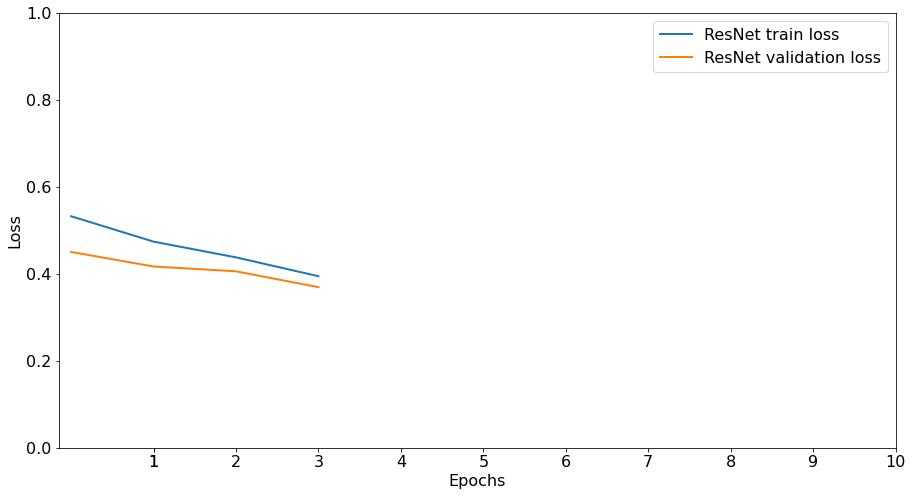

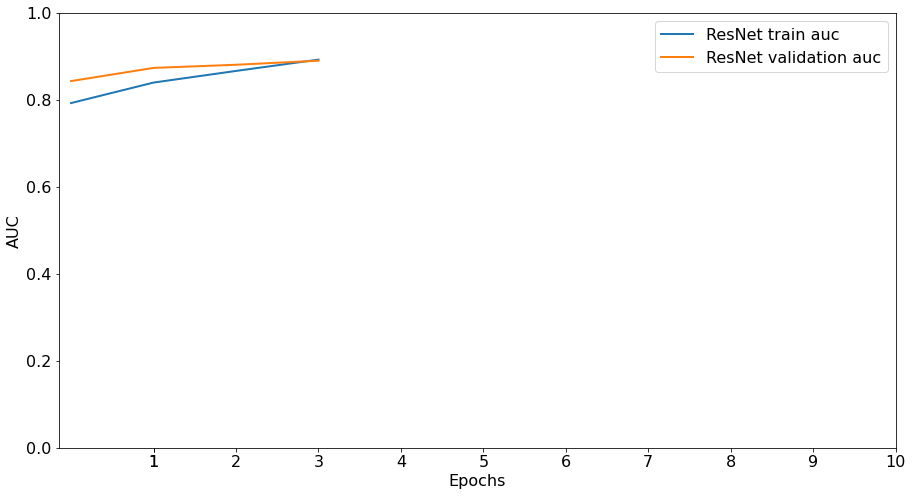

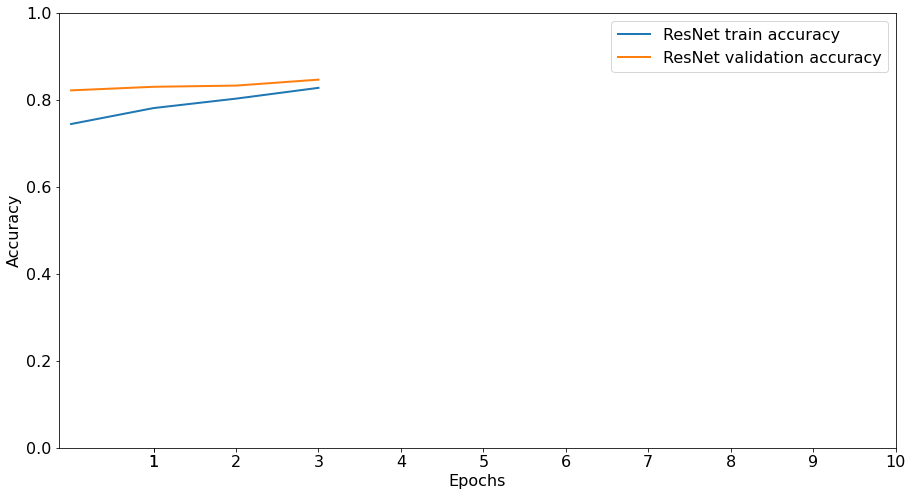

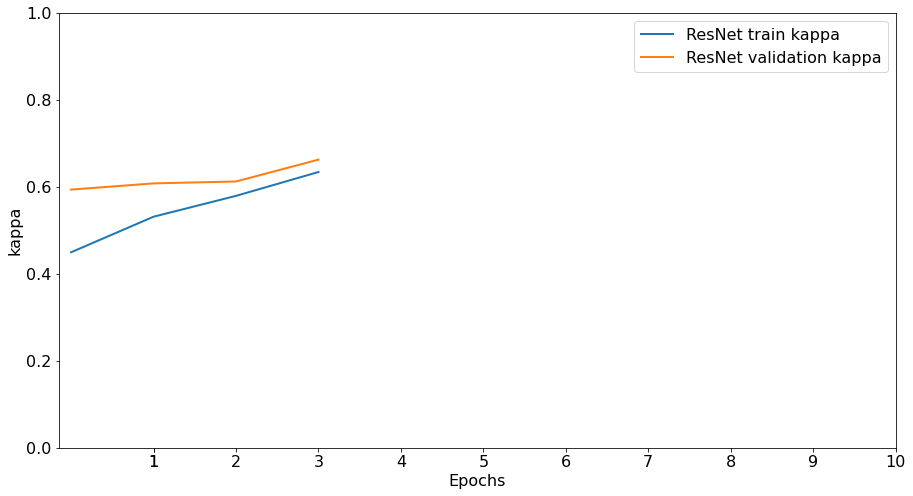

In [42]:
epochs = 10

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests

early_stop = EarlyStopping(monitor="kappa",
                           mode="min", 
                           patience=3, 
                           restore_best_weights=True)

resnet_model = resnet_builder(pooling='avg', trainable_layers_after=-5)

resnet_model.compile(optimizer=Adam(), 
                     loss= BinaryCrossentropy(from_logits=False),
                     metrics=[metrics()])

resnet_model.summary()

hs = resnet_model.fit(train_iter,
                      validation_data = valid_generator, 
                      epochs = epochs,
                      callbacks=[reduce_lr, early_stop])

print('Finished training.')
print('------------------')

resnet_model_eval = resnet_model.evaluate(test_generator)
print_results(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

In [43]:
print_results_without_plots(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

Train Loss     : 0.39458
Validation Loss: 0.36927
Test Loss      : 0.55433
---
Train AUC     : 0.89260
Validation AUC: 0.89010
Test AUC      : 0.81667
---
Train Accuracy     : 0.82772
Validation Accuracy: 0.84658
Test Accuracy      : 0.71761
---
Train Kappa     : 0.63418
Validation Kappa: 0.63418
Test Kappa      : 0.43597


In [44]:
filename = 'tmp/models/model6v2.h5'
resnet_model.save(filename)

Model 6 is the RESNET152v2 and the best score so far is with -5 unfrozen layers

In [39]:
print_results_without_plots(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

Train Loss     : 0.40645
Validation Loss: 0.42411
Test Loss      : 0.49538
---
Train AUC     : 0.89092
Validation AUC: 0.86810
Test AUC      : 0.84148
---
Train Accuracy     : 0.82178
Validation Accuracy: 0.81918
Test Accuracy      : 0.75083
---
Train Kappa     : 0.62172
Validation Kappa: 0.62172
Test Kappa      : 0.50164


In [40]:
filename = 'tmp/models/model6v2.h5'
resnet_model.save(filename)

In [124]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa",mode="min", patience=3, restore_best_weights=True)
resnet_model = resnet_builder(pooling='avg')
resnet_model.compile(optimizer=Adam(), loss= BinaryCrossentropy(from_logits=False),metrics=[metrics()])
hs = resnet_model.fit(train_generator,validation_data = valid_generator, epochs = epochs,callbacks=[early_stop])
print('Finished training.')
print('------------------')
resnet_model.summary()
filename = 'tmp/models/model6.h5'
resnet_model.save(filename)
# Evaluate on test data and show all the results.
resnet_model_eval = resnet_model.evaluate(test_generator)
clean_up(model=resnet_model)
print_results_without_plots(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

234545216/234545216 [==============================] - 244s 1us/step
Epoch 1/50
23/23 [==============================] - 66s 3s/step - loss: 0.6118 - auc: 0.6762 - accuracy: 0.6671 - kappa: 0.2197 - val_loss: 0.5639 - val_auc: 0.7460 - val_accuracy: 0.7370 - val_kappa: 0.3553
Epoch 2/50
23/23 [==============================] - 59s 3s/step - loss: 0.5119 - auc: 0.8036 - accuracy: 0.7699 - kappa: 0.4638 - val_loss: 0.5127 - val_auc: 0.7973 - val_accuracy: 0.7671 - val_kappa: 0.4626
Epoch 3/50
23/23 [==============================] - 80s 4s/step - loss: 0.4694 - auc: 0.8414 - accuracy: 0.7979 - kappa: 0.5378 - val_loss: 0.4902 - val_auc: 0.8138 - val_accuracy: 0.7890 - val_kappa: 0.5019
Epoch 4/50
23/23 [==============================] - 101s 4s/step - loss: 0.4471 - auc: 0.8566 - accuracy: 0.8110 - kappa: 0.5710 - val_loss: 0.4771 - val_auc: 0.8254 - val_accuracy: 0.8110 - val_kappa: 0.5501
Finished training.
------------------
Model: "resnet"
____________________________________________

#### **Model 7: RESNET50 Architecture**

In [47]:
def RESNET50_builder(pooling="max", shape=(256, 256, 3), trainable_layers_after=None):
    RESNET = ResNet50(include_top=False,weights='imagenet',input_shape=shape,pooling=pooling)
    if trainable_layers_after:
        for layer in RESNET.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        RESNET.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(layers=[RESNET,prediction_layer],name="VGGNET")
    return model

not good results, maybe wont include after all, slow and bad results

In [ ]:
epochs = 10
early_stop = EarlyStopping(monitor="kappa",
                           mode="min",
                           patience=5,
                           restore_best_weights=True)

RESNET50_model = RESNET50_builder(pooling='avg',trainable_layers_after=-70)

RESNET50_model.compile(optimizer=Adam(), 
                       loss= BinaryCrossentropy(from_logits=False),
                       metrics=[metrics()])

RESNET50_model.summary()    

hs = RESNET50_model.fit(train_iter,
                        validation_data = valid_generator, 
                        epochs = epochs,
                        callbacks=[reduce_lr, early_stop])
                        
print('Finished training.')
print('------------------')
RESNET50_model.summary()
filename = 'tmp/models/model7.h5'
RESNET50_model.save(filename)
VGGNET_model_eval = RESNET50_model.evaluate(test_generator)
clean_up(model=RESNET50_model)
print_results(model_name='RESNET50_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

In [ ]:
print_results_without_plots(model_name='RESNET50_model',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

Train Loss     : 0.61990
Validation Loss: 0.65912
Test Loss      : 0.75274
---
Train AUC     : 0.68303
Validation AUC: 0.59907
Test AUC      : 0.57962
---
Train Accuracy     : 0.65184
Validation Accuracy: 0.60274
Test Accuracy      : 0.49169
---
Train Kappa     : 0.20930
Validation Kappa: 0.20930
Test Kappa      : -0.01329


#### **Model 8: Densenet201 (With Max Pooling and MLP)**

In [128]:
epochs = 30
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=5, restore_best_weights=True)
densenet_model = densenet_builder(pooling='max',trainable_layers_after=600,mlp=[512, 512],mlp_dropout=0.2)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = 'tmp/models/model8.h5'
densenet_model.save(filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Epoch 1/30
23/23 [==============================] - 76s 3s/step - loss: 1.8120 - auc: 0.5882 - accuracy: 0.6068 - kappa: 0.1519 - val_loss: 0.8735 - val_auc: 0.8051 - val_accuracy: 0.7233 - val_kappa: 0.2609
Epoch 2/30
23/23 [==============================] - 64s 3s/step - loss: 0.4916 - auc: 0.8287 - accuracy: 0.7856 - kappa: 0.5253 - val_loss: 0.5442 - val_auc: 0.8471 - val_accuracy: 0.8247 - val_kappa: 0.5753
Epoch 3/30
23/23 [==============================] - 82s 4s/step - loss: 0.3404 - auc: 0.9157 - accuracy: 0.8740 - kappa: 0.7194 - val_loss: 0.5652 - val_auc: 0.8532 - val_accuracy: 0.8329 - val_kappa: 0.5960
Epoch 4/30
23/23 [==============================] - 86s 4s/step - loss: 0.2355 - auc: 0.9630 - accuracy: 0.9027 - kappa: 0.7895 - val_loss: 0.6400 - val_auc: 0.8490 - val_accuracy: 0.8164 - val_kappa: 0.5509
Epoch 5/30
23/23 [==============================] - 91s 4s/step - loss: 0.1898 - auc: 0.9745 - accuracy: 0.9240 - kappa: 0.8334 - val_loss: 0.5526 - val_auc: 0.8590 - v

In [130]:
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.07818
Validation Loss: 0.65465
Test Loss      : 1.24132
---
Train AUC     : 0.99600
Validation AUC: 0.85799
Test AUC      : 0.79618
---
Train Accuracy     : 0.96849
Validation Accuracy: 0.82740
Test Accuracy      : 0.54817
---
Train Kappa     : 0.93176
Validation Kappa: 0.93176
Test Kappa      : 0.09900


#### **Model 9: Densenet121**

In [132]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

In [133]:
epochs = 30
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.25)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)

29084464/29084464 [==============================] - 14s 0us/step
Epoch 1/30
23/23 [==============================] - 40s 2s/step - loss: 0.7107 - auc: 0.5937 - accuracy: 0.6185 - kappa: 0.1317 - val_loss: 0.5830 - val_auc: 0.7421 - val_accuracy: 0.6986 - val_kappa: 0.2336
Epoch 2/30
23/23 [==============================] - 28s 1s/step - loss: 0.5555 - auc: 0.7521 - accuracy: 0.7158 - kappa: 0.3520 - val_loss: 0.5552 - val_auc: 0.8051 - val_accuracy: 0.7644 - val_kappa: 0.5023
Epoch 3/30
23/23 [==============================] - 29s 1s/step - loss: 0.5121 - auc: 0.7916 - accuracy: 0.7637 - kappa: 0.4667 - val_loss: 0.4857 - val_auc: 0.8222 - val_accuracy: 0.7726 - val_kappa: 0.4481
Epoch 4/30
23/23 [==============================] - 30s 1s/step - loss: 0.4667 - auc: 0.8369 - accuracy: 0.7911 - kappa: 0.5253 - val_loss: 0.4505 - val_auc: 0.8432 - val_accuracy: 0.8000 - val_kappa: 0.5296
Epoch 5/30
23/23 [==============================] - 31s 1s/step - loss: 0.4281 - auc: 0.8677 - accurac

In [134]:
print_results_without_plots(model_name='DenseNet121',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Train Loss     : 0.35149
Validation Loss: 0.44996
Test Loss      : 0.71320
---
Train AUC     : 0.91008
Validation AUC: 0.84996
Test AUC      : 0.72775
---
Train Accuracy     : 0.84658
Validation Accuracy: 0.78904
Test Accuracy      : 0.57143
---
Train Kappa     : 0.66121
Validation Kappa: 0.66121
Test Kappa      : 0.14479


In [135]:
filename = 'tmp/models/model9.h5'
densenet_model.save(filename)

#### **Model 10: Densenet201** 

In [137]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

In [138]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=10,restore_best_weights=True)
densenet_model = densenet_builder(pooling='max', trainable_layers_after=600)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = 'tmp/models/model10.h5'
densenet_model.save(filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Epoch 1/50
23/23 [==============================] - 76s 3s/step - loss: 1.0423 - auc: 0.7320 - accuracy: 0.6979 - kappa: 0.3461 - val_loss: 3.3669 - val_auc: 0.6729 - val_accuracy: 0.4493 - val_kappa: 0.1045
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: 0.3516 - auc: 0.9255 - accuracy: 0.8692 - kappa: 0.7172 - val_loss: 0.7202 - val_auc: 0.8552 - val_accuracy: 0.7836 - val_kappa: 0.5467
Epoch 3/50
23/23 [==============================] - 58s 3s/step - loss: 0.1121 - auc: 0.9914 - accuracy: 0.9658 - kappa: 0.9253 - val_loss: 0.9436 - val_auc: 0.8453 - val_accuracy: 0.7041 - val_kappa: 0.4210
Epoch 4/50
23/23 [==============================] - 61s 3s/step - loss: 0.0352 - auc: 0.9999 - accuracy: 0.9945 - kappa: 0.9882 - val_loss: 0.6490 - val_auc: 0.8586 - val_accuracy: 0.7753 - val_kappa: 0.5351
Epoch 5/50
23/23 [==============================] - 70s 3s/step - loss: 0.0163 - auc: 1.0000 - accuracy: 0.9993 - kappa: 0.9985 - val_loss: 0.5247 - val_auc: 0.8705 - v

#### **Model 11: DensetNet169**

In [196]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet169(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

-----------------------------

Trying data augmentation and trainable after 550 layers

In [215]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=10,restore_best_weights=True)
densenet_model = densenet_builder(pooling='max', trainable_layers_after=550)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
densenet_model.summary()

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 262, 262, 3)  0          ['input_18[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_34[0][0]']      
                                )                                                          

In [216]:
hs = densenet_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr, early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model_eval = densenet_model.evaluate(test_generator)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

Epoch 1/50
23/23 [==============================] - 66s 2s/step - loss: 0.7356 - auc: 0.7766 - accuracy: 0.7363 - kappa: 0.4253 - val_loss: 0.6984 - val_auc: 0.8375 - val_accuracy: 0.7836 - val_kappa: 0.5292 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 43s 2s/step - loss: 0.3854 - auc: 0.9067 - accuracy: 0.8500 - kappa: 0.6714 - val_loss: 0.8633 - val_auc: 0.8413 - val_accuracy: 0.7397 - val_kappa: 0.4806 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 58s 3s/step - loss: 0.2466 - auc: 0.9575 - accuracy: 0.9055 - kappa: 0.7929 - val_loss: 0.6359 - val_auc: 0.8532 - val_accuracy: 0.8192 - val_kappa: 0.5960 - lr: 1.0000e-04
Epoch 4/50
23/23 [==============================] - 65s 3s/step - loss: 0.1969 - auc: 0.9721 - accuracy: 0.9288 - kappa: 0.8434 - val_loss: 0.5720 - val_auc: 0.8471 - val_accuracy: 0.8082 - val_kappa: 0.5715 - lr: 1.0000e-04
Epoch 5/50
23/23 [==============================] - 63s 3s/step - loss: 0.1620 - auc: 0.9823 - accuracy: 0.9

In [ ]:
filename = 'tmp/models/model11.h5'
densenet_model.save(filename)

-------

In [140]:
epochs = 50
early_stop = EarlyStopping(monitor="kappa", mode="min", patience=10,restore_best_weights=True)
densenet_model = densenet_builder(pooling='max', trainable_layers_after=600)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_generator,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[early_stop]
    )
print('Finished training.')
print('------------------')
densenet_model.summary()
filename = 'tmp/models/model11.h5'
densenet_model.save(filename)
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

51877672/51877672 [==============================] - 126s 2us/step
Epoch 1/50
23/23 [==============================] - 54s 2s/step - loss: 1.3601 - auc: 0.4823 - accuracy: 0.5336 - kappa: -0.0057 - val_loss: 1.1138 - val_auc: 0.4684 - val_accuracy: 0.6055 - val_kappa: -0.0514
Epoch 2/50
23/23 [==============================] - 47s 2s/step - loss: 0.9544 - auc: 0.5153 - accuracy: 0.5884 - kappa: 0.0560 - val_loss: 0.8456 - val_auc: 0.5502 - val_accuracy: 0.6192 - val_kappa: 0.1111
Epoch 3/50
23/23 [==============================] - 61s 3s/step - loss: 0.7965 - auc: 0.6002 - accuracy: 0.6192 - kappa: 0.1522 - val_loss: 0.7628 - val_auc: 0.6224 - val_accuracy: 0.6740 - val_kappa: 0.1992
Epoch 4/50
23/23 [==============================] - 71s 3s/step - loss: 0.7024 - auc: 0.6660 - accuracy: 0.6582 - kappa: 0.2438 - val_loss: 0.6815 - val_auc: 0.6685 - val_accuracy: 0.6959 - val_kappa: 0.2763
Epoch 5/50
23/23 [==============================] - 67s 3s/step - loss: 0.6458 - auc: 0.7118 - accu

#### **Model 12: InceptionV3**

Data augmentation - preparing to fit the data on inception and xception

In [174]:
from keras.applications.inception_v3 import preprocess_input 
#If we want preprocess input for densnet its different

batch_size = 64 #128
rotation_range = 30
brightness_range = None #[0.9,1.2]
standardisation = False #if false, just rescale

train_less = train_images_paths[train_images_paths["category"] == "XR_FOREARM"]
valid_less = valid_data_paths[valid_data_paths["category"] == "XR_FOREARM"]

X_train = image_loader(train_less['image_path'][:50,],im_size)

y_train = train_less['label']
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

X_test = image_loader(valid_less['image_path'][:50,],im_size)

y_test = valid_less['label']
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

train, valid = train_test_split(train_less, test_size=0.2,random_state=seed)

test = valid_less.drop(['dir'], axis=1)
################### DATA AUGMENTATION ########################
train_gen = ImageDataGenerator(
    rotation_range= rotation_range ,
    brightness_range= brightness_range,
    horizontal_flip= True,
    fill_mode="constant",
    cval=0.0,
    preprocessing_function = preprocess_input
)
train_iter = train_gen.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
##############################################################
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

path = 'MURA-v1.1'

train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

CLASSES = 2
input_shape = (im_size,im_size,3)

100%|██████████| 50/50 [00:00<00:00, 461.08it/s]

Found 1460 non-validated image filenames.
Found 1460 non-validated image filenames.
Found 365 validated image filenames.
Found 301 validated image filenames.


In [180]:
def define_model():
  trainable_layers_after = 270
  inception_model = InceptionV3(input_shape=(256,256,3), 
                        weights= 'imagenet',
                        include_top= False,
                        pooling= 'avg')
  # Froze some layers because the model is overfitting, maybe reduce the complexity
  if trainable_layers_after:
      for layer in inception_model.layers[:trainable_layers_after]:
          layer.trainable = False
  else:
      inception_model.trainable = False
  x = inception_model.output
  predictions = Dense(1,activation='sigmoid',name="final")(x)
  model = Model(inputs=inception_model.input,outputs=predictions)
  return model


inception_model = define_model()
inception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = BinaryCrossentropy(from_logits=False), 
              metrics=[metrics()])
inception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_470 (Batch  (None, 127, 127, 32  96         ['conv2d_470[0][0]']             
 Normalization)                 )                                                           

In [181]:
epochs = 35

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
                           
#verbose for model.evaluate(), validation_split in model.fit
history = inception_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr]
    )
print('Finished training.')
print('------------------')
filename = 'tmp/models/model12.h5'
inception_model.save(filename)
inception_model_eval = inception_model.evaluate(test_generator)
clean_up(model=inception_model)
print_results_without_plots(model_name='InceptionV3',epochs= epochs,hs = hs,model_eval = inception_model_eval)

Epoch 1/35
23/23 [==============================] - 28s 973ms/step - loss: 0.5082 - auc: 0.8063 - accuracy: 0.7699 - kappa: 0.4782 - val_loss: 1.0264 - val_auc: 0.8313 - val_accuracy: 0.6904 - val_kappa: 0.2029 - lr: 1.0000e-04
Epoch 2/35
23/23 [==============================] - 17s 730ms/step - loss: 0.3904 - auc: 0.8863 - accuracy: 0.8452 - kappa: 0.6508 - val_loss: 0.4762 - val_auc: 0.8534 - val_accuracy: 0.8274 - val_kappa: 0.6010 - lr: 1.0000e-04
Epoch 3/35
23/23 [==============================] - 18s 755ms/step - loss: 0.3494 - auc: 0.9113 - accuracy: 0.8589 - kappa: 0.6806 - val_loss: 0.5209 - val_auc: 0.8498 - val_accuracy: 0.8137 - val_kappa: 0.5629 - lr: 1.0000e-04
Epoch 4/35
23/23 [==============================] - 19s 817ms/step - loss: 0.3113 - auc: 0.9345 - accuracy: 0.8836 - kappa: 0.7383 - val_loss: 0.5018 - val_auc: 0.8519 - val_accuracy: 0.8192 - val_kappa: 0.5813 - lr: 1.0000e-05
Epoch 5/35
23/23 [==============================] - 20s 855ms/step - loss: 0.2967 - auc:

In [182]:
print_results_without_plots(model_name='InceptionV3',epochs= epochs,hs = hs,model_eval = inception_model_eval)

Train Loss     : 0.02296
Validation Loss: 0.52457
Test Loss      : 0.51300
---
Train AUC     : 0.99997
Validation AUC: 0.84464
Test AUC      : 0.85547
---
Train Accuracy     : 0.99521
Validation Accuracy: 0.82192
Test Accuracy      : 0.78738
---
Train Kappa     : 0.98958
Validation Kappa: 0.98958
Test Kappa      : 0.57514


#### **Model 13: Xception**

In [131]:
import tempfile

def add_regularization(model, regularizer):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

! RUN this with 120 layers frozen and see if it overfits less!

In [136]:
def define_model():
  trainable_layers_after = 120
  xception_model = Xception(input_shape=(256,256,3), 
                        weights= 'imagenet',
                        include_top= False,
                        pooling= 'avg')
  # Froze some layers because the model is overfitting, maybe reduce the complexity
  if trainable_layers_after:
      for layer in xception_model.layers[:trainable_layers_after]:
          layer.trainable = False
  else:
      xception_model.trainable = False
  x = xception_model.output
  predictions = Dense(1,activation='sigmoid',name="final")(x)
  model = Model(inputs=xception_model.input,outputs=predictions)
  return model



xception_model = define_model()
xception_model = add_regularization(xception_model, tf.keras.regularizers.l2(0.000001)) #Applying regularisation
xception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = BinaryCrossentropy(from_logits=False), 
              metrics=[metrics()])
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [133]:
#TESTING L2 REG.
xception_model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.00015286884>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00062291033>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0001960799>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00026603029>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0005764157>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00065466284>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.014106e-06>]

In [66]:
clean_up(model=xception_model)

...Finished clean up...


In [137]:
epochs = 35

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
                           
#verbose for model.evaluate(), validation_split in model.fit
history = xception_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr]
    )
print('Finished training.')
print('------------------')
filename = 'tmp/models/model13.h5'
xception_model.save(filename)
xception_model_eval = xception_model.evaluate(test_generator)
clean_up(model=xception_model)
print_results_without_plots(model_name='Xception',epochs= epochs,hs = hs,model_eval = xception_model_eval)

Epoch 1/35
23/23 [==============================] - 48s 2s/step - loss: 0.5996 - auc: 0.7520 - accuracy: 0.6904 - kappa: 0.3420 - val_loss: 0.6267 - val_auc: 0.8061 - val_accuracy: 0.6630 - val_kappa: 0.1095 - lr: 1.0000e-04
Epoch 2/35
23/23 [==============================] - 44s 2s/step - loss: 0.4581 - auc: 0.8494 - accuracy: 0.8151 - kappa: 0.5781 - val_loss: 0.8545 - val_auc: 0.8253 - val_accuracy: 0.6658 - val_kappa: 0.1184 - lr: 1.0000e-04
Epoch 3/35
23/23 [==============================] - 49s 2s/step - loss: 0.4060 - auc: 0.8841 - accuracy: 0.8452 - kappa: 0.6508 - val_loss: 0.9170 - val_auc: 0.8295 - val_accuracy: 0.6658 - val_kappa: 0.1184 - lr: 1.0000e-05
Epoch 4/35
23/23 [==============================] - 73s 3s/step - loss: 0.3943 - auc: 0.8931 - accuracy: 0.8452 - kappa: 0.6511 - val_loss: 0.9160 - val_auc: 0.8323 - val_accuracy: 0.6795 - val_kappa: 0.1624 - lr: 1.0000e-06
Epoch 5/35
23/23 [==============================] - 87s 4s/step - loss: 0.4043 - auc: 0.8859 - accur

In [138]:
print_results_without_plots(model_name='Xception',epochs= epochs,hs = hs,model_eval = xception_model_eval)

Train Loss     : 0.02296
Validation Loss: 0.52457
Test Loss      : 0.55279
---
Train AUC     : 0.99997
Validation AUC: 0.84464
Test AUC      : 0.80168
---
Train Accuracy     : 0.99521
Validation Accuracy: 0.82192
Test Accuracy      : 0.73090
---
Train Kappa     : 0.98958
Validation Kappa: 0.98958
Test Kappa      : 0.46237


### **Results**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Basic CNN | 0.70550 | 0.55814 | 0.11855 |
| CNN + Dropout + AdaBound | 0.93843 | 0.52492 | 0.05118 | 
| Densenet201 | 2.98349 | 0.56146 | 0.12039 | 
| **Densenet201 + Avg Pooling + Mlp** | 0.53257 | **0.78738** | 0.57493 |
| Densenet201 + Max Pooling + Mlp | 1.24132 | 0.54817 | 0.09900 |
| Densenet121 + Avg Pooling + Mlp | 0.71320 | 0.57143 | 0.14479 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| VGG19 | 0.72133 | 0.49834 | 0.00000 |
| RESNET152v2 | 0.49538 | 0.75083 | 0.50164 |
| RESNET50 | 0.75583 | 0.49834 | 0.00000 |
| InceptionV3 | **0.51300** | 0.78738 | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |

I am keeping the 5 best regarding test loss. I will be using those 5 to test the other body parts as well and also use them together as ensemble.

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| RESNET152v2 | **0.49538** | 0.75083 | 0.50164 |
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | 0.51300 | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

### **Ensemble** 

I have choose the best models do be a part of this ensemble, those models are: 

* Densenet201
* Resnet152
* VGG16
* Inception V3
* Xception

In [43]:
def load_all_models_eval():
    for i in range(5):
        filename = 'tmp/best_models/model' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)

In [44]:
load_all_models_eval()

tmp/best_models/model1.h5
>loaded tmp/best_models/model1.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5499 - auc: 0.8599 - accuracy: 0.7874 - kappa: 0.5750
...Finished clean up...
...Finished clean up...
tmp/best_models/model2.h5
>loaded tmp/best_models/model2.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5543 - auc: 0.8167 - accuracy: 0.7176 - kappa: 0.4360
...Finished clean up...
...Finished clean up...
tmp/best_models/model3.h5
>loaded tmp/best_models/model3.h5
5/5 [==============================] - 8s 1s/step - loss: 0.6613 - auc: 0.8450 - accuracy: 0.7641 - kappa: 0.5283
...Finished clean up...
...Finished clean up...
tmp/best_models/model4.h5
>loaded tmp/best_models/model4.h5
5/5 [==============================] - 4s 504ms/step - loss: 0.5130 - auc: 0.8555 - accuracy: 0.7874 - kappa: 0.5751
...Finished clean up...
...Finished clean up...
tmp/best_models/model5.h5
>loaded tmp/best_models/model5.h5
5/5 [==============================] - 8s 1s/st

In [45]:
def ens_all_models_load():
    all_models = list()
    for i in range(5):
        filename = 'tmp/best_models/model' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        
    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models] 
    yAvg=average(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)  
   
    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [ ]:
modelEns = ens_all_models()

In [47]:
pred_ens = modelEns.predict(test_generator)

5/5 [==============================] - 45s 7s/step


In [48]:
cohen_kappa_score((pred_ens> 0.5), test.label_index)

0.6149536832818703

In [49]:
accuracy_score( (pred_ens> 0.5), test.label_index)

0.8073089700996677

### ! **Different body parts** - Just change the train less and valid less and then the folder to save the models

#### Data loading

In [36]:
from keras.applications.inception_v3 import preprocess_input 
#If we want preprocess input for densnet its different

batch_size = 64 #128
rotation_range = 30
brightness_range = None #[0.9,1.2]
standardisation = False #if false, just rescale

# Selecting Body part 
# ['XR_HAND', 
#  'XR_HUMERUS',
#  'XR_FINGER',
#  'XR_ELBOW',
#  'XR_SHOULDER',
#  'XR_WRIST',
#  'XR_FOREARM']

train_less = train_images_paths[train_images_paths["category"] == "XR_WRIST"]
valid_less = valid_data_paths[valid_data_paths["category"] == "XR_WRIST"]

X_train = image_loader(train_less['image_path'][:50,],im_size)

y_train = train_less['label']
Y_train = y_train.replace("positive",1)
Y_train = Y_train.replace("negative",0)

X_test = image_loader(valid_less['image_path'][:50,],im_size)

y_test = valid_less['label']
Y_test = y_test.replace("positive",1)
Y_test = Y_test.replace("negative",0)

train, valid = train_test_split(train_less, test_size=0.2,random_state=seed)

test = valid_less.drop(['dir'], axis=1)

################### DATA AUGMENTATION ########################
train_gen = ImageDataGenerator(
    rotation_range= rotation_range ,
    brightness_range= brightness_range,
    horizontal_flip= True,
    fill_mode="constant",
    cval=0.0,
    preprocessing_function = preprocess_input
)
train_iter = train_gen.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
##############################################################
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)

path = 'MURA-v1.1'

train_generator = image_generator.flow_from_dataframe(dataframe = train,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=False,seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest',validate_filenames=True,seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'image_path',y_col = 'label_index',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest', validate_filenames=True,seed=seed)

CLASSES = 2
input_shape = (im_size,im_size,3)

100%|██████████| 50/50 [00:00<00:00, 657.42it/s]


Found 7801 non-validated image filenames.
Found 7801 non-validated image filenames.
Found 1951 validated image filenames.
Found 659 validated image filenames.


#### Modelling

#### Densenet201

Epoch 1/30
122/122 [==============================] - 290s 2s/step - loss: 0.4845 - auc: 0.8328 - accuracy: 0.7767 - kappa: 0.5245 - val_loss: 0.5294 - val_auc: 0.8643 - val_accuracy: 0.7868 - val_kappa: 0.5351 - lr: 0.0010
Epoch 2/30
122/122 [==============================] - 312s 3s/step - loss: 0.4087 - auc: 0.8802 - accuracy: 0.8235 - kappa: 0.6230 - val_loss: 0.4502 - val_auc: 0.8748 - val_accuracy: 0.7975 - val_kappa: 0.5616 - lr: 0.0010
Epoch 3/30
122/122 [==============================] - 324s 3s/step - loss: 0.3831 - auc: 0.8955 - accuracy: 0.8369 - kappa: 0.6525 - val_loss: 0.4140 - val_auc: 0.8790 - val_accuracy: 0.8160 - val_kappa: 0.6139 - lr: 0.0010
Epoch 4/30
122/122 [==============================] - 378s 3s/step - loss: 0.3711 - auc: 0.9026 - accuracy: 0.8449 - kappa: 0.6695 - val_loss: 0.4971 - val_auc: 0.8746 - val_accuracy: 0.7955 - val_kappa: 0.5537 - lr: 0.0010
Epoch 5/30
122/122 [==============================] - 398s 3s/step - loss: 0.3275 - auc: 0.9232 - accura

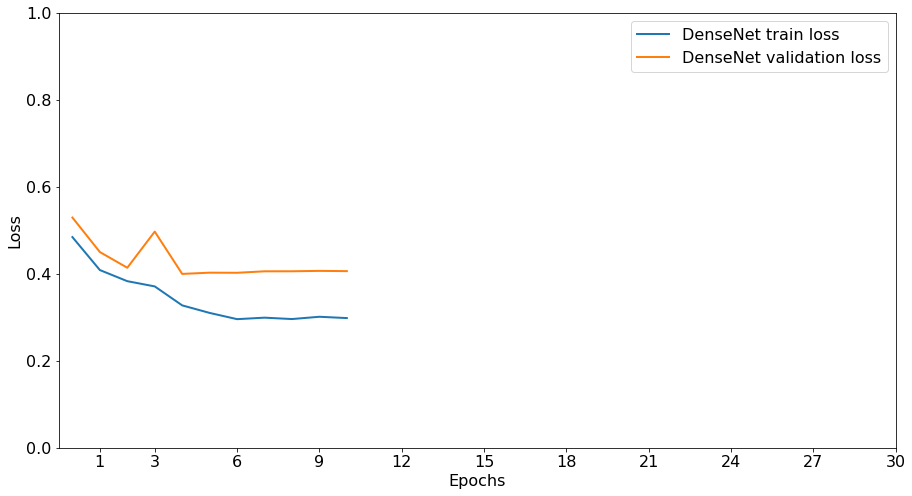

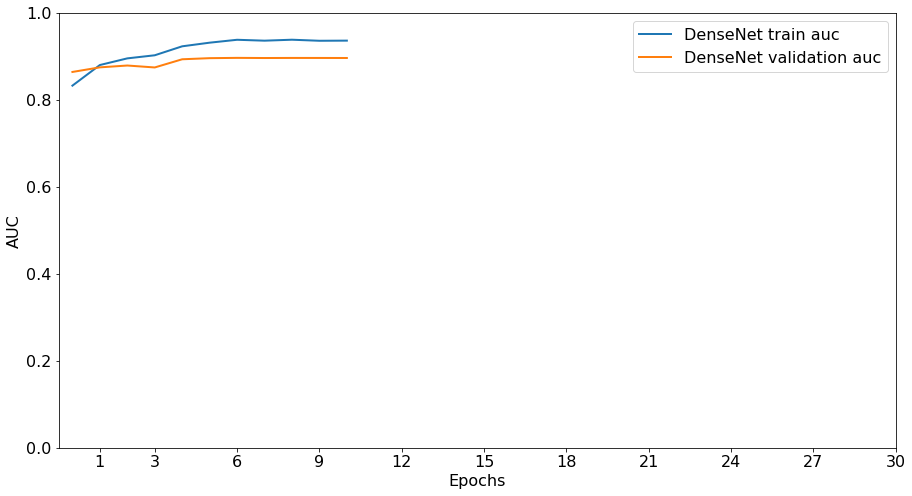

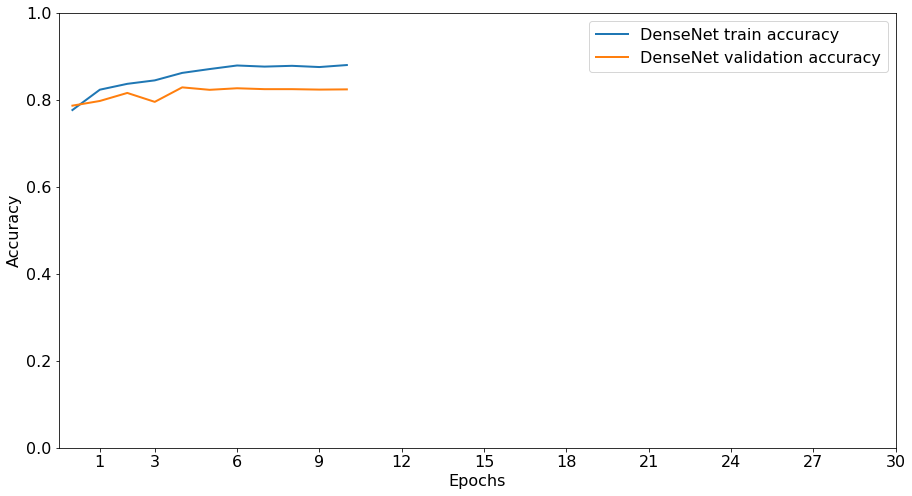

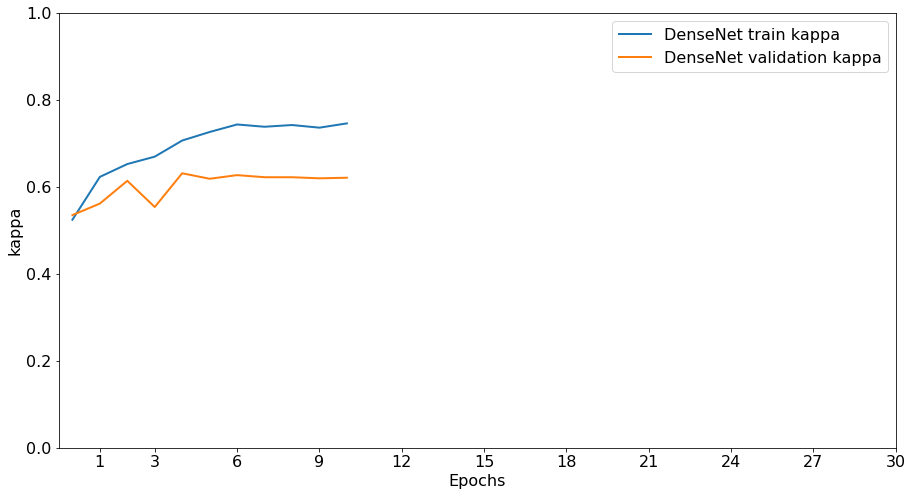

Train Loss     : 0.29829
Validation Loss: 0.40626
Test Loss      : 0.60363
---
Train AUC     : 0.93628
Validation AUC: 0.89635
Test AUC      : 0.84872
---
Train Accuracy     : 0.88014
Validation Accuracy: 0.82419
Test Accuracy      : 0.75569
---
Train Kappa     : 0.74594
Validation Kappa: 0.74594
Test Kappa      : 0.48356


In [48]:
def densenet_builder(
        pooling="avg",
        shape=(256, 256, 3),
        trainable_layers_after=None,
        mlp=[],
        mlp_dropout=0.25,
        nameNN="",
):
    denseNet = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in denseNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        denseNet.trainable = False
    output = denseNet.output
    for index, mlp_neurons in enumerate(mlp):
        output = Dense(mlp_neurons, activation="relu", name=f"m.{index}.{mlp_neurons}")(output)
        if mlp_dropout:
            output = Dropout(mlp_dropout, name=f"mdp.{index}.{mlp_neurons}")(output)
    output = Dense(1, activation="sigmoid", name="densenet_output_sigmoid")(output)
    model = Model(denseNet.input, output, name='densenet'+nameNN)
    return model

epochs = 30

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
densenet_model = densenet_builder(
                            pooling='avg',
                            trainable_layers_after=600,
                            mlp=[512, 512],
                            mlp_dropout=0.25)
densenet_model.compile(optimizer=Adam(), 
                  loss= BinaryCrossentropy(from_logits=False),
                  metrics=[metrics()])
hs = densenet_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr,early_stop]
    )
print('Finished training.')
print('------------------')

filename = 'tmp/XR_WRIST/model1.h5'
densenet_model.save(filename)
densenet_model.summary()
densenet_model_eval = densenet_model.evaluate(test_generator)
clean_up(model=densenet_model)
print_results(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)
print_results_without_plots(model_name='DenseNet',epochs= epochs,hs = hs,model_eval = densenet_model_eval)

#### Resnet

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 resnet_output_sigmoid (Dens  (None, 1)                2049      
 e)                                                              
                                                                 
Total params: 58,333,697
Trainable params: 1,056,769
Non-trainable params: 57,276,928
_________________________________________________________________
Epoch 1/10
122/122 [==============================] - 637s 5s/step - loss: 0.5356 - auc: 0.8014 - accuracy: 0.7464 - kappa: 0.4648 - val_loss: 1.0078 - val_auc: 0.7813 - val_accuracy: 0.5613 - val_kappa: 0.1981 - lr: 0.0010
Epoch 2/10
122/122 [==============================] - 721s 6s/step - loss: 0.4695 - auc: 0.8465 - accuracy: 0.7855 - kappa: 0.5455 - val_loss: 0.6

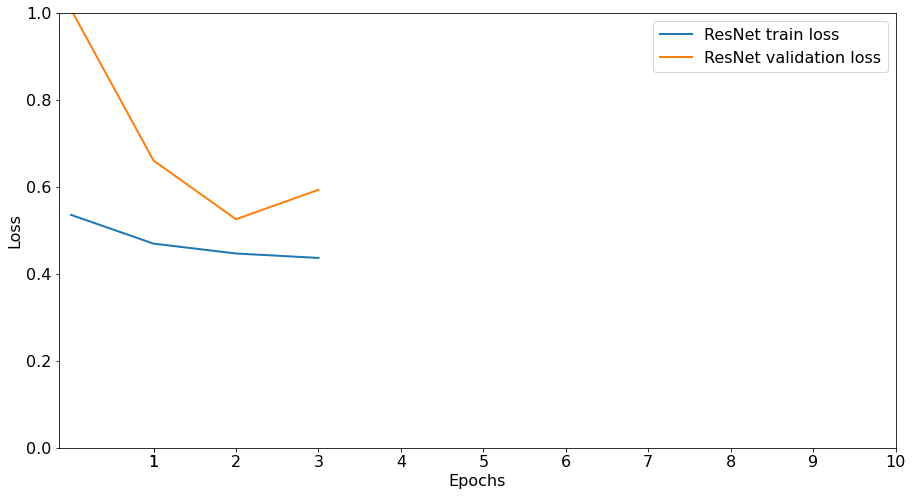

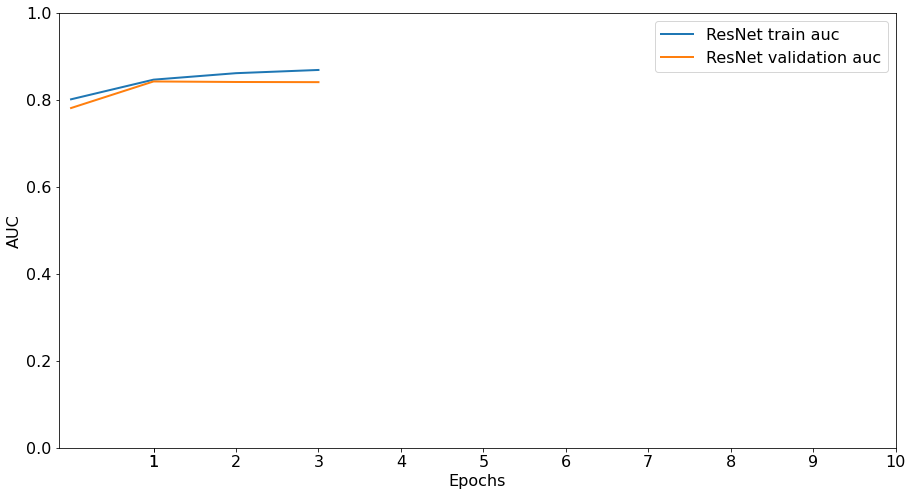

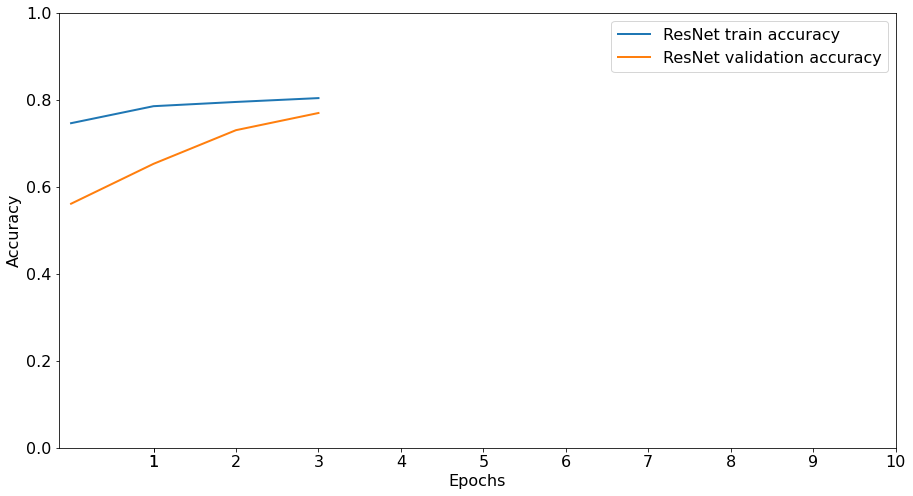

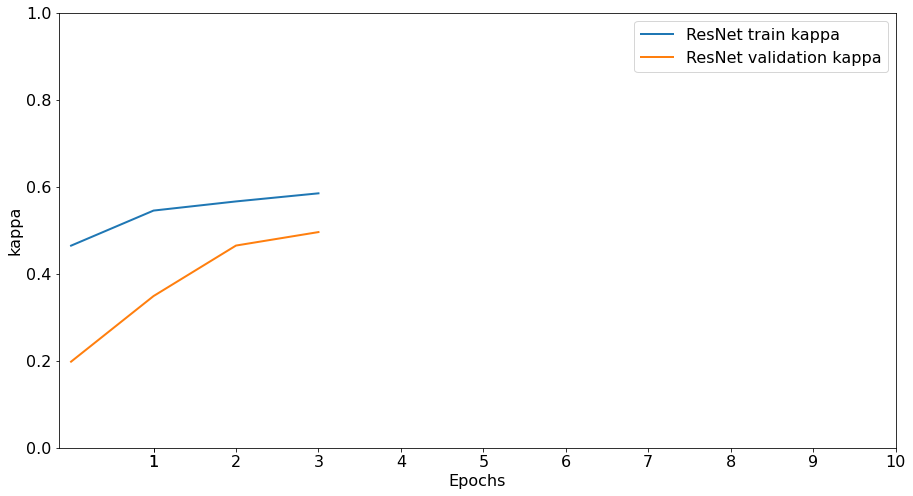

In [49]:
def resnet_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    resNet = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in resNet.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        resNet.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",
                                name="resnet_output_sigmoid")
    model = Sequential(
        layers=[
            resNet,
            prediction_layer
        ],
        name="resnet"
    )
    return model

epochs = 10

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests

early_stop = EarlyStopping(monitor="kappa",
                           mode="min", 
                           patience=3, 
                           restore_best_weights=True)

resnet_model = resnet_builder(pooling='avg', trainable_layers_after=-5)

resnet_model.compile(optimizer=Adam(), 
                     loss= BinaryCrossentropy(from_logits=False),
                     metrics=[metrics()])

resnet_model.summary()

hs = resnet_model.fit(train_iter,
                      validation_data = valid_generator, 
                      epochs = epochs,
                      callbacks=[reduce_lr, early_stop])

print('Finished training.')
print('------------------')

filename = 'tmp/XR_WRIST/model2.h5'
resnet_model.save(filename)

resnet_model_eval = resnet_model.evaluate(test_generator)
print_results(model_name='ResNet',epochs= epochs,hs = hs, model_eval = resnet_model_eval)

#### VGG16

In [50]:
def VGGNET16_builder(
        pooling="max", 
        shape=(256, 256, 3), 
        trainable_layers_after=None
    ):
    VGGNET16 = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
        pooling=pooling
    )
    if trainable_layers_after:
        for layer in VGGNET16.layers[:trainable_layers_after]:
            layer.trainable = False
    else:
        VGGNET16.trainable = False
    prediction_layer = Dense(1, activation="sigmoid",name="VGGNET_output_sigmoid")
    model = Sequential(
        layers=[
            VGGNET16,
            prediction_layer
        ],
        name="VGGNET16"
    )
    return model

epochs = 5
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=1,
                              mode='auto') # Just like the paper suggests

VGGNET_model16 = VGGNET16_builder(pooling='avg', 
                                  trainable_layers_after=16)

VGGNET_model16.compile(optimizer=Adam(),
                       loss= BinaryCrossentropy(from_logits=False),
                       metrics=[metrics()])

hs = VGGNET_model16.fit(train_iter,
                        validation_data = valid_generator, 
                        epochs = epochs,
                        callbacks=[reduce_lr, early_stop])
print('Finished training.')
print('------------------')
VGGNET_model16.summary()
filename = 'tmp/XR_WRIST/model3.h5'
VGGNET_model16.save(filename)

VGGNET_model_eval = VGGNET_model16.evaluate(test_generator)
clean_up(model=VGGNET_model16)
print_results(model_name='VGGNET_model16',epochs= epochs,hs = hs,model_eval = VGGNET_model_eval)

Epoch 1/5
  1/122 [..............................] - ETA: 8:38 - loss: 0.7146 - auc: 0.4148 - accuracy: 0.5469 - kappa: 0.0000e+00

#### Inception V3

In [ ]:
def define_model():
  trainable_layers_after = 270
  inception_model = InceptionV3(input_shape=(256,256,3), 
                        weights= 'imagenet',
                        include_top= False,
                        pooling= 'avg')
  # Froze some layers because the model is overfitting, maybe reduce the complexity
  if trainable_layers_after:
      for layer in inception_model.layers[:trainable_layers_after]:
          layer.trainable = False
  else:
      inception_model.trainable = False
  x = inception_model.output
  predictions = Dense(1,activation='sigmoid',name="final")(x)
  model = Model(inputs=inception_model.input,outputs=predictions)
  return model


inception_model = define_model()
inception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = BinaryCrossentropy(from_logits=False), 
              metrics=[metrics()])
inception_model.summary()

epochs = 35

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
                           
#verbose for model.evaluate(), validation_split in model.fit
history = inception_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr, early_stop]
    )
print('Finished training.')
print('------------------')
filename = 'tmp/FullBody/model4.h5'
inception_model.save(filename)
inception_model_eval = inception_model.evaluate(test_generator)
clean_up(model=inception_model)
print_results_without_plots(model_name='InceptionV3',epochs= epochs,hs = hs,model_eval = inception_model_eval)

In [70]:
inception_model_eval = inception_model.evaluate(test_generator)
clean_up(model=inception_model)
print_results_without_plots(model_name='InceptionV3',epochs= epochs,hs = history,model_eval = inception_model_eval)

50/50 [==============================] - 25s 495ms/step - loss: 0.5241 - auc: 0.8092 - accuracy: 0.7360 - kappa: 0.4683
...Finished clean up...
Train Loss     : 0.30816
Validation Loss: 0.54677
Test Loss      : 0.52414
---
Train AUC     : 0.93942
Validation AUC: 0.80782
Test AUC      : 0.80915
---
Train Accuracy     : 0.87085
Validation Accuracy: 0.75767
Test Accuracy      : 0.73600
---
Train Kappa     : 0.72772
Validation Kappa: 0.72772
Test Kappa      : 0.46835


#### Xception

In [ ]:
import tempfile

def add_regularization(model, regularizer):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
def define_model():
  trainable_layers_after = 120
  xception_model = Xception(input_shape=(256,256,3), 
                        weights= 'imagenet',
                        include_top= False,
                        pooling= 'avg')
  # Froze some layers because the model is overfitting, maybe reduce the complexity
  if trainable_layers_after:
      for layer in xception_model.layers[:trainable_layers_after]:
          layer.trainable = False
  else:
      xception_model.trainable = False
  x = xception_model.output
  predictions = Dense(1,activation='sigmoid',name="final")(x)
  model = Model(inputs=xception_model.input,outputs=predictions)
  return model



xception_model = define_model()
xception_model = add_regularization(xception_model, tf.keras.regularizers.l2(0.000001)) #Applying regularisation
xception_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = BinaryCrossentropy(from_logits=False), 
              metrics=[metrics()])
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
epochs = 35

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1,mode='min') # Just like the paper suggests
early_stop = EarlyStopping(monitor="kappa", 
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)
                           
#verbose for model.evaluate(), validation_split in model.fit
history = xception_model.fit(
        train_iter,
        validation_data = valid_generator, 
        epochs = epochs,
        callbacks=[reduce_lr, early_stop]
    )
print('Finished training.')
print('------------------')
filename = 'tmp/XR_WRIST/model5.h5'
xception_model.save(filename)
xception_model_eval = xception_model.evaluate(test_generator)
clean_up(model=xception_model)
print_results_without_plots(model_name='Xception',epochs= epochs,hs = hs,model_eval = xception_model_eval)

Epoch 1/35
105/105 [==============================] - 468s 4s/step - loss: 0.5928 - auc: 0.7591 - accuracy: 0.6955 - kappa: 0.3911 - val_loss: 0.8034 - val_auc: 0.7684 - val_accuracy: 0.5925 - val_kappa: 0.1812 - lr: 1.0000e-04
Epoch 2/35
105/105 [==============================] - 452s 4s/step - loss: 0.5165 - auc: 0.8254 - accuracy: 0.7543 - kappa: 0.5084 - val_loss: 0.7031 - val_auc: 0.7852 - val_accuracy: 0.6510 - val_kappa: 0.2995 - lr: 1.0000e-04
Epoch 3/35
105/105 [==============================] - 457s 4s/step - loss: 0.4879 - auc: 0.8461 - accuracy: 0.7711 - kappa: 0.5422 - val_loss: 0.6384 - val_auc: 0.8106 - val_accuracy: 0.6814 - val_kappa: 0.3608 - lr: 1.0000e-04
Epoch 4/35
105/105 [==============================] - 414s 4s/step - loss: 0.4662 - auc: 0.8594 - accuracy: 0.7789 - kappa: 0.5577 - val_loss: 0.6030 - val_auc: 0.8155 - val_accuracy: 0.7076 - val_kappa: 0.4137 - lr: 1.0000e-04
Epoch 5/35
105/105 [==============================] - 360s 3s/step - loss: 0.4487 - auc:

#### Ensemble

In [ ]:
def load_all_models_eval():
    for i in range(5):
        filename = 'tmp/XR_WRIST/model' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        model_eval = model.evaluate(test_generator)
        clean_up(model=model)
        clean_up(model=model_eval)

In [ ]:
load_all_models_eval()

tmp/XR_SHOULDER/model1.h5
>loaded tmp/XR_SHOULDER/model1.h5
9/9 [==============================] - 33s 3s/step - loss: 0.5675 - auc: 0.8022 - accuracy: 0.7229 - kappa: 0.4441
...Finished clean up...
...Finished clean up...
tmp/XR_SHOULDER/model2.h5
>loaded tmp/XR_SHOULDER/model2.h5
9/9 [==============================] - 40s 4s/step - loss: 0.7452 - auc: 0.7539 - accuracy: 0.6412 - kappa: 0.2770
...Finished clean up...
...Finished clean up...
tmp/XR_SHOULDER/model3.h5
>loaded tmp/XR_SHOULDER/model3.h5
9/9 [==============================] - 24s 3s/step - loss: 0.6931 - auc: 0.5000 - accuracy: 0.5062 - kappa: 0.0000e+00
...Finished clean up...
...Finished clean up...
tmp/XR_SHOULDER/model4.h5
>loaded tmp/XR_SHOULDER/model4.h5
9/9 [==============================] - 13s 1s/step - loss: 0.5594 - auc: 0.7955 - accuracy: 0.7371 - kappa: 0.4727
...Finished clean up...
...Finished clean up...
tmp/XR_SHOULDER/model5.h5
>loaded tmp/XR_SHOULDER/model5.h5
9/9 [==============================] - 22s 2

In [ ]:
def ens_all_models_load():
    all_models = list()
    for i in range(5):
        filename = 'tmp/XR_WRIST/model' + str(i + 1) + '.h5'
        print(filename)
        print('>loaded %s' % filename)
        model = load_model(filename,custom_objects={'metrics':metrics})
        model._name = "Model_Name"+ str(i + 1)
        all_models.append(model)
        clean_up(model=model)
        
    return all_models

def ensembleModels(models, model_input,nameip):
    yModels=[model(model_input) for model in models] 
    yAvg=average(yModels) 
    modelEns = Model(inputs=model_input, outputs=yAvg, name=nameip)  
   
    return modelEns

def ens_all_models():
    members = ens_all_models_load()
    print('Loaded %d models' % len(members))
    model_input = Input(shape=input_shape)
    modelEns = ensembleModels(members, model_input,"modelEnsemble")
    return modelEns

In [ ]:
modelEns = ens_all_models()

tmp/XR_SHOULDER/model1.h5
>loaded tmp/XR_SHOULDER/model1.h5
...Finished clean up...
tmp/XR_SHOULDER/model2.h5
>loaded tmp/XR_SHOULDER/model2.h5
...Finished clean up...
tmp/XR_SHOULDER/model3.h5
>loaded tmp/XR_SHOULDER/model3.h5
...Finished clean up...
tmp/XR_SHOULDER/model4.h5
>loaded tmp/XR_SHOULDER/model4.h5
...Finished clean up...
tmp/XR_SHOULDER/model5.h5
>loaded tmp/XR_SHOULDER/model5.h5
...Finished clean up...
Loaded 5 models


In [ ]:
pred_ens = modelEns.predict(test_generator)

9/9 [==============================] - 110s 11s/step


In [ ]:
cohen_kappa_score((pred_ens> 0.5), test.label_index)

0.44643208302408643

In [ ]:
accuracy_score( (pred_ens> 0.5), test.label_index)

0.7246891651865008

#### **Results:** 

**FULL DATA**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

**XR_FOREARM**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | 0.78738 | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | 0.51300 | 0.78738 | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          | **0.80730** | **0.61495** |

**XR_HAND**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.65416 | 0.66522 | 0.22118 |
| ResnetV2 | 1.73864 | 0.59565 | 0.01865 | 
| VGG16 | 0.73608 | 0.59130 | 0.01551 |
| **InceptionV3** | **0.56396** | **0.71957** | **0.37196** |
| Xception | 0.69626  | 0.71087 | 0.35023 |
| Ensemble |          | 0.62608 | 0.11254 |

**XR_HUMERUS**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

**XR_FINGER**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

**XR_ELBOW**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

**XR_SHOULDER**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |

**XR_WRIST**

| Architecture | Test loss | Test accuracy | Test Kappa | 
| --- | --- | --- | --- | 
| Densenet201 | 0.53257 | **0.78738** | 0.57493 |
| Densenet169 | 0.67100 | 0.77741 | 0.55504 | 
| VGG16 | 0.50226 | 0.76744 | 0.53527 |
| **InceptionV3** | **0.51300** | **0.78738** | **0.57514** |
| Xception | 0.55279  | 0.73090 | 0.46237 |
| Ensemble |          |         |         |